In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer

import lightgbm
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_data = pd.read_csv('traininingdata.txt', sep=';')
test_data = pd.read_csv('testdata.txt', sep=';')

# 0. Data Exploration

In [4]:
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,divorced,secondary,no,-78,yes,yes,cellular,29,jul,10,23,-1,0,unknown,no
1,50,management,married,tertiary,no,106,yes,no,unknown,15,may,388,2,-1,0,unknown,no
2,47,admin.,married,secondary,no,407,yes,no,unknown,5,jun,67,12,-1,0,unknown,no
3,39,admin.,divorced,secondary,no,952,yes,no,unknown,16,jun,62,1,-1,0,unknown,no
4,30,management,single,tertiary,no,364,no,no,cellular,30,apr,306,2,-1,0,unknown,yes


In [5]:
train_data.shape

(36168, 17)

In [6]:
test_data.shape

(9043, 17)

## Check whether there is null value

In [7]:
print(f"Train Set has {train_data.isnull().any().sum()} null values")
print(f"Test Set has {test_data.isnull().any().sum()} null values")

Train Set has 0 null values
Test Set has 0 null values


The dataset is complete without null values. Here, we treat every ``"unknown"`` value as a kind of that variable.

In [8]:
ctg_features=['job', 'default', 'education','contact', 'housing', 'loan','marital', 'month', 'poutcome']
dic={}
for i in ctg_features:
    label,num=np.unique(train_data[i],return_counts=True)
    if "unknown" in label:
        dic[i]=num[np.where(label=="unknown")]
        print("The number of 'unknown'in "+i+":"+str(dic[i]))

The number of 'unknown'in job:[232]
The number of 'unknown'in education:[1496]
The number of 'unknown'in contact:[10458]
The number of 'unknown'in poutcome:[29623]


## Check whether duplicates exist

In [9]:
print(f"Train Set has {train_data.duplicated().any().sum()} duplicated values")
print(f"Test Set has {test_data.duplicated().any().sum()} duplicated values")

Train Set has 0 duplicated values
Test Set has 0 duplicated values


## Check whether the data is balanced

In [10]:
print(f'the distribution of y in train:\n{train_data.y.value_counts()/len(train_data)}')
print(f'the distribution of y in test:\n{test_data.y.value_counts()/len(test_data)}')

the distribution of y in train:
no     0.883018
yes    0.116982
Name: y, dtype: float64
the distribution of y in test:
no     0.883003
yes    0.116997
Name: y, dtype: float64


As we can see, it's very imbalanced. The ratio of `'No'`:`'Yes'` reaches almost 8:1.

## Description

In [11]:
print(train_data.describe(include='all'))

                 age          job  marital  education default        balance  \
count   36168.000000        36168    36168      36168   36168   36168.000000   
unique           NaN           12        3          4       2            NaN   
top              NaN  blue-collar  married  secondary      no            NaN   
freq             NaN         7804    21795      18556   35518            NaN   
mean       40.942076          NaN      NaN        NaN     NaN    1365.055989   
std        10.616610          NaN      NaN        NaN     NaN    3098.191637   
min        18.000000          NaN      NaN        NaN     NaN   -8019.000000   
25%        33.000000          NaN      NaN        NaN     NaN      72.000000   
50%        39.000000          NaN      NaN        NaN     NaN     448.000000   
75%        48.000000          NaN      NaN        NaN     NaN    1422.250000   
max        95.000000          NaN      NaN        NaN     NaN  102127.000000   

       housing   loan   contact        

In [12]:
#classify the features into continuous type(ctn) and categorical type(ctg)
ctn_features=['age', 'balance','day','duration','campaign', 'pdays', 'previous']
ctg_features=['contact', 'default', 'education', 'housing', 'job', 'loan','marital', 'month', 'poutcome']

## Visualization

In this part, we will characterize each of the features and show their dependencies to result of campaign directly.

### Numerical Features

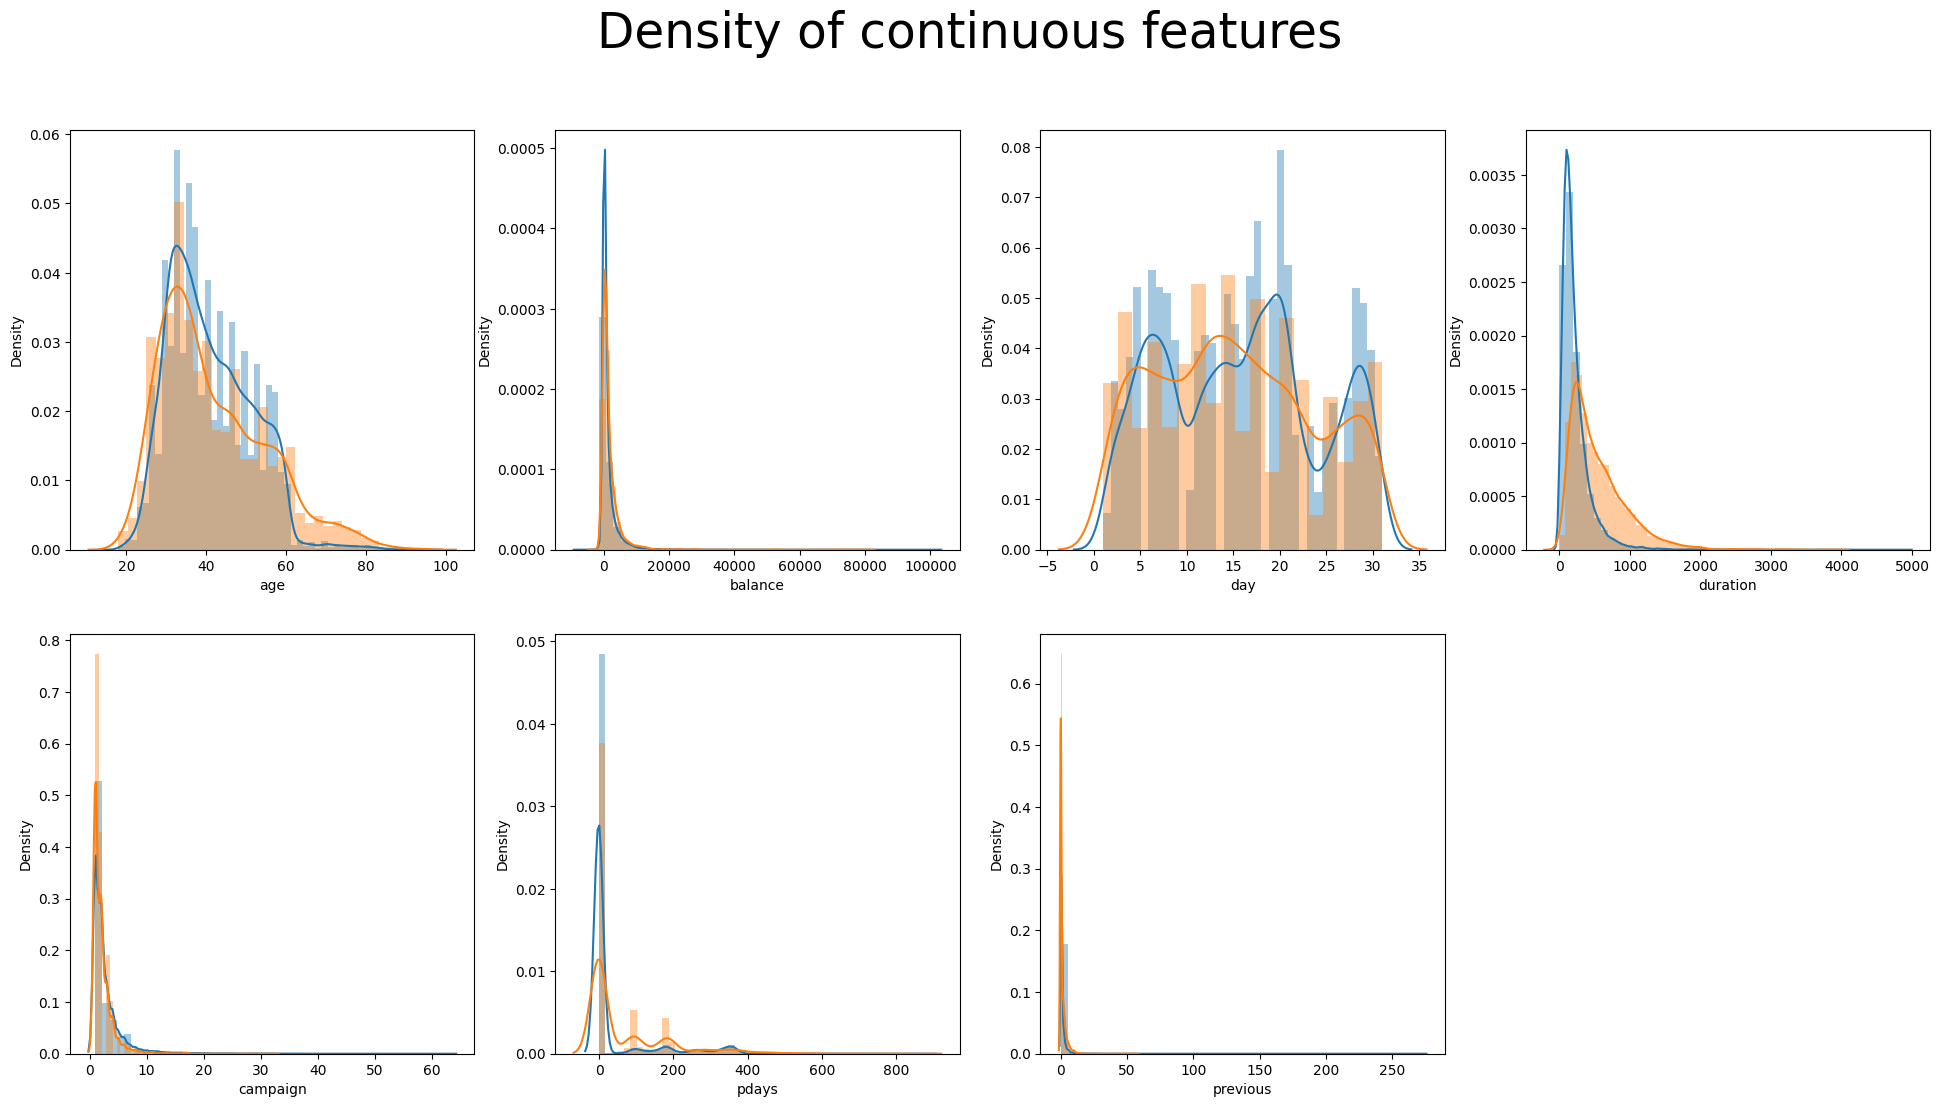

In [13]:
fig, ax = plt.subplots(2,4, figsize=(24,12))
for i in range(len(ctn_features)):
    #sn.kdeplot(x=ctn_features[i],hue='y',shade=True,data=train,ax=ax[i//4][i%4])    
    sns.distplot(train_data[ctn_features[i]][train_data.y=='no'],hist=True,kde=True,ax=ax[i//4][i%4])
    sns.distplot(train_data[ctn_features[i]][train_data.y=='yes'],hist = True, kde = True,ax=ax[i//4][i%4])
    #plt.legend(['yes', 'no'],prop={'size':0.5})
    plt.xlim([train_data[ctn_features[i]].quantile(0.001),train_data[ctn_features[i]].quantile(0.95)])
plt.legend(['yes', 'no'])
plt.suptitle("Density of continuous features",fontsize=35)
fig.delaxes(ax[1,3]) #
plt.savefig("ctn_featr.png", dpi=750, bbox_inches = 'tight')#transparent=True

look into ineresting variables:

- age

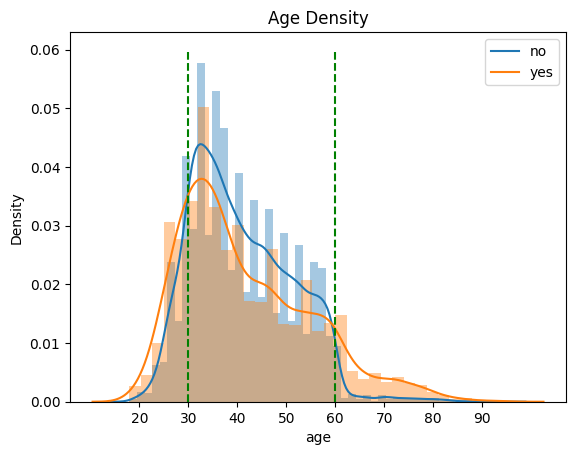

In [14]:
sns.distplot(train_data['age'][train_data.y=='no'],hist=True,kde=True)
sns.distplot(train_data['age'][train_data.y=='yes'],hist = True, kde = True)

plt.legend(['no', 'yes'])
plt.xticks([20,30,40,50,60,70,80,90])
plt.vlines(30,0,0.06,ls='dashed',color='g')
plt.vlines(60,0,0.06,ls='dashed',color='g')
plt.title('Age Density')
plt.savefig("age_distr.png", dpi=750, bbox_inches = 'tight')#transparent=True

In [15]:
blue=sns.color_palette("Paired",8)[0]
orange=sns.color_palette("Paired",8)[7]

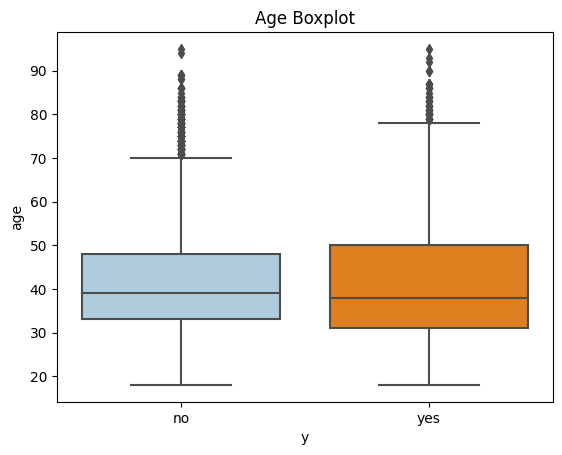

In [16]:
my_pal = {"yes": orange, "no": blue}
sns.boxplot(train_data['y'],train_data['age'],palette=my_pal)
plt.title('Age Boxplot')
plt.savefig("age_boxplot.png", dpi=750, bbox_inches = 'tight')#transparent=True

We can see that when `age` > 60 or `age` < 25 , the tail of `yes` is thicker than `no`. It means that the elders and the youth tend to buy the product, which seems reasonable because the two groups are more persuassive. 

Thus, we can divide `age` into < 25, 25 to 60, >60 three subgroups.

- duration

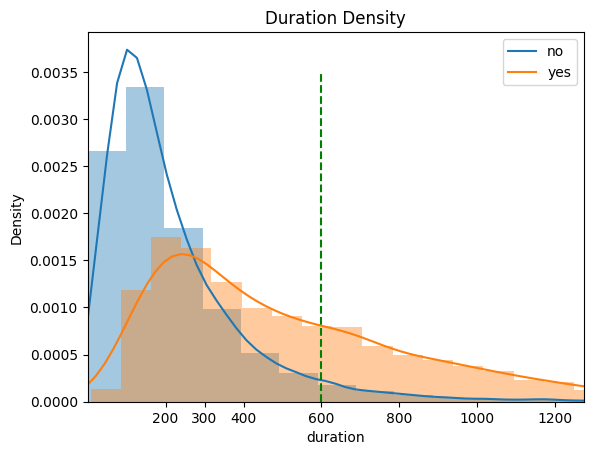

In [17]:
sns.distplot(train_data['duration'][train_data.y=='no'],hist=True,kde=True)
sns.distplot(train_data['duration'][train_data.y=='yes'],hist = True, kde = True)

plt.xlim([0,train_data.duration.quantile(0.99)])
plt.legend(['no', 'yes'])
plt.vlines(600,0,0.0035,color='g',ls='dashed')
plt.xticks([200,300,400,600,800,1000,1200])
plt.title("Duration Density")
plt.savefig("duration_distr.png", dpi=750, bbox_inches = 'tight')#transparent=True

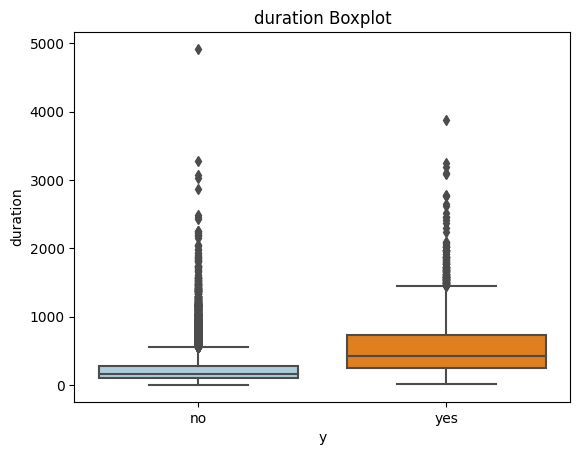

In [18]:
my_pal = {"yes": orange, "no": blue}
sns.boxplot(train_data['y'],train_data['duration'],palette=my_pal)
plt.title('duration Boxplot')
plt.savefig("duration_boxplot.png", dpi=750, bbox_inches = 'tight')#transparent=True

- balance

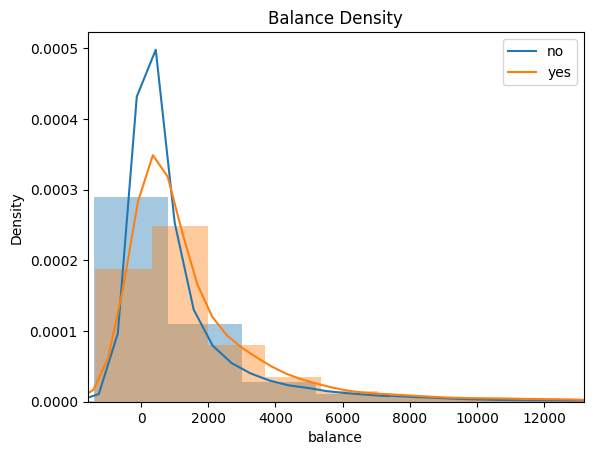

In [19]:
sns.distplot(train_data['balance'][train_data.y=='no'],hist=True,kde=True)
sns.distplot(train_data['balance'][train_data.y=='yes'],hist = True, kde = True)

plt.xlim([train_data['balance'].quantile(0.001),train_data['balance'].quantile(0.99)])
plt.legend(['no', 'yes'])
plt.title('Balance Density')
#plt.vlines(300,0,0.0035,color='g',ls='dashed')
#plt.xticks([200,300,400,600,800,1000,1200])
plt.savefig("balance_distr.png", dpi=750, bbox_inches = 'tight')#transparent=True

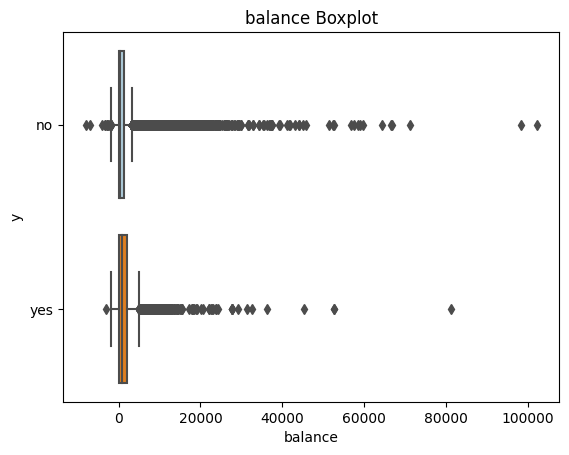

In [20]:
my_pal = {"yes": orange, "no": blue}
sns.boxplot(y=train_data['y'],x=train_data['balance'],palette=my_pal)
plt.title('balance Boxplot')
#plt.figure(figsize=(30,10))
plt.savefig("balance_boxplot.png", dpi=750)#transparent=True

The distributions are largely overlapped, we may consider the `balance` feature not so helpful.

- campaign

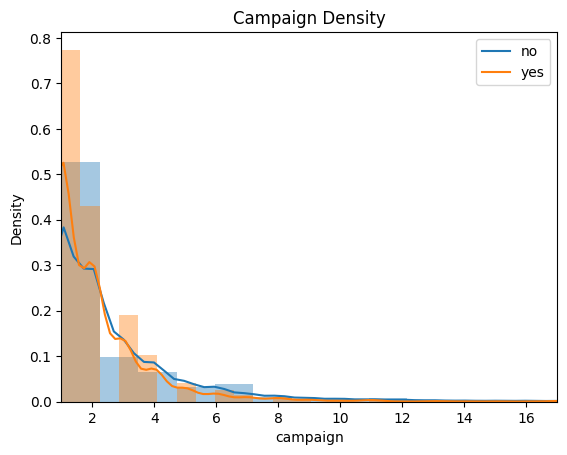

In [21]:
sns.distplot(train_data['campaign'][train_data.y=='no'],hist=True,kde=True)
sns.distplot(train_data['campaign'][train_data.y=='yes'],hist = True, kde = True)

plt.xlim([train_data.campaign.quantile(0.01),train_data.campaign.quantile(0.99)])
plt.title('Campaign Density')
plt.legend(['no', 'yes'])
plt.savefig("Campaign_distr.png", dpi=750, bbox_inches = 'tight')

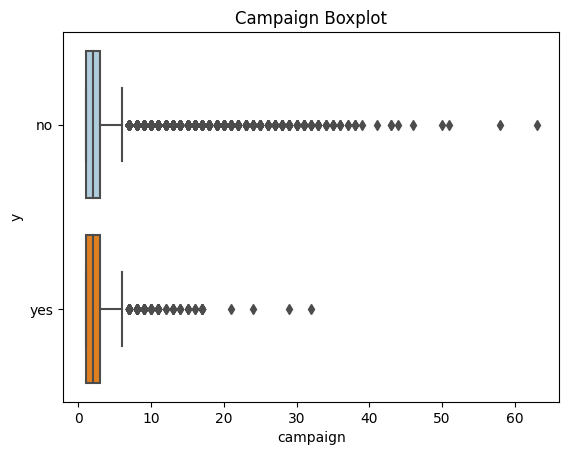

In [22]:
my_pal = {"yes": orange, "no": blue}
sns.boxplot(y=train_data['y'],x=train_data['campaign'],palette=my_pal)
plt.title('Campaign Boxplot')
#plt.figure(figsize=(30,10))
plt.savefig("campaign_boxplot.png", dpi=750, bbox_inches = 'tight')#transparent=True

- previous

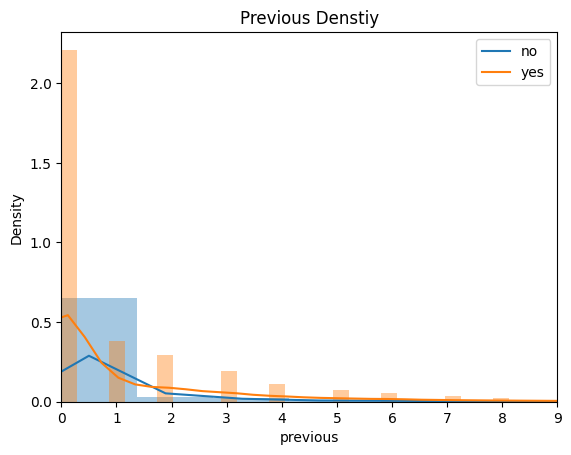

In [23]:
vrname='previous'
sns.distplot(train_data[vrname][train_data.y=='no'],hist=True,kde=True,bins=200)
sns.distplot(train_data[vrname][train_data.y=='yes'],hist=True,kde=True,bins=200)
plt.xlim([train_data[vrname].quantile(0),train_data[vrname].quantile(0.99)])
plt.legend(['no', 'yes'])
#plt.xlim(0,7)
plt.title("Previous Denstiy")
plt.savefig(vrname+"_distr.png", dpi=750, bbox_inches = 'tight')

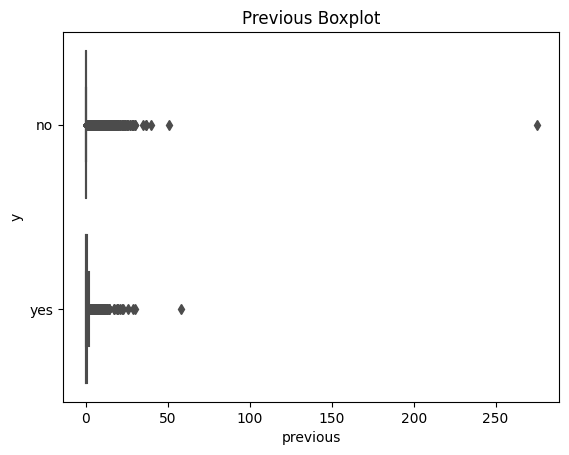

In [24]:
sns.boxplot(y=train_data['y'],x=train_data['previous'],palette=my_pal)
plt.title('Previous Boxplot')
#plt.figure(figsize=(18,4))
plt.savefig("previous_boxplot.png", dpi=750, bbox_inches = 'tight')#transparent=True

- pdays

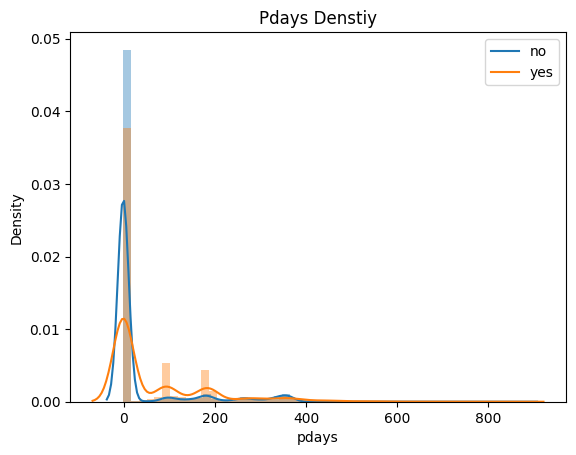

In [25]:
vrname='pdays'
sns.distplot(train_data['pdays'][train_data.y=='no'],hist=True,kde=True)
sns.distplot(train_data['pdays'][train_data.y=='yes'],hist=True,kde=True)

#plt.xlim([train_data[vrname].quantile(0),train_data[vrname].quantile(0.99)])
plt.legend(['no', 'yes'])
#plt.xlim(0,7)
plt.title("Pdays Denstiy")
plt.savefig(vrname+"_distr.png", dpi=750, bbox_inches = 'tight')

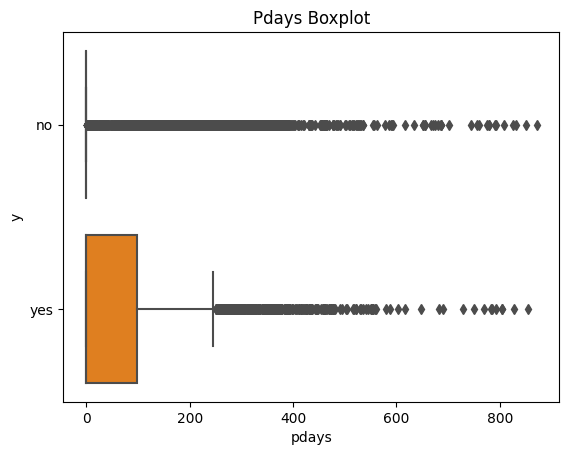

In [26]:
sns.boxplot(y=train_data['y'],x=train_data['pdays'],palette=my_pal)
plt.title('Pdays Boxplot')
#plt.figure(figsize=(18,4))
plt.savefig("pdays_boxplot.png", dpi=750, bbox_inches = 'tight')#transparent=True

For numerical variable, we find that `age`,`duration` have different distributions between `yes` and `no` two groups. However, the other 5 features seem to have similar distributions between the two groups. Then, we try to divide `age` and `duration` into subgroups.

### Categorical Features

- job

In [27]:
ageorder=train_data.groupby('job').apply(lambda x:sum(x.y=='yes')/sum(x.y=='no')).sort_values(axis=0)
ageorder_index=list(ageorder.index)
ageorder

job
blue-collar      0.078645
housemaid        0.090100
entrepreneur     0.090909
services         0.094496
unknown          0.120773
technician       0.123114
self-employed    0.126095
admin.           0.142426
management       0.162383
unemployed       0.184807
retired          0.298497
student          0.392193
dtype: float64

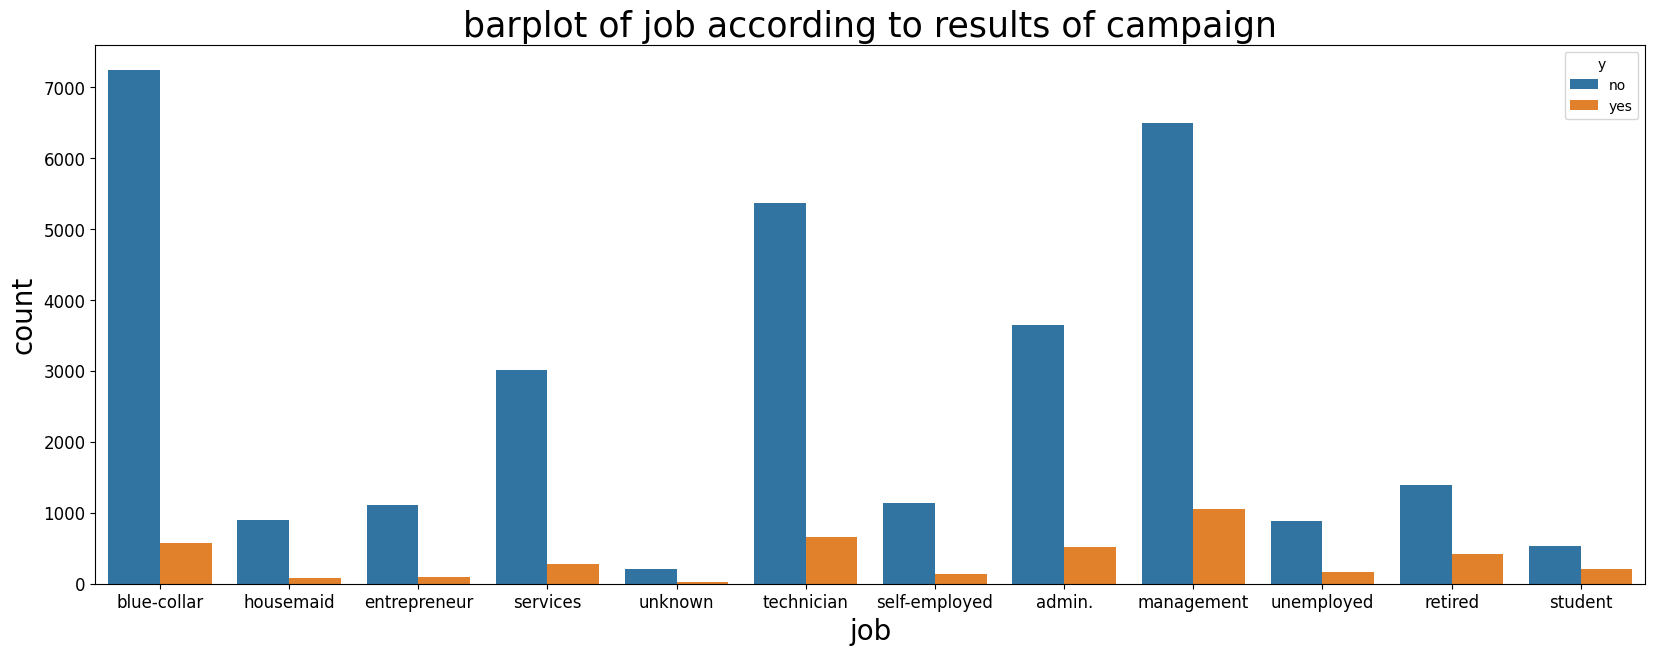

In [28]:
plt.figure(figsize=(20, 7))
sns.countplot(x='job',hue='y',data=train_data,order=ageorder_index)
plt.xticks(size=12,rotation=0)
plt.yticks(size=12)
plt.xlabel('job',fontdict={'size':20})
plt.ylabel('count',fontdict={'size':20})
plt.title('barplot of job according to results of campaign',fontdict={'size':25})
plt.savefig("job.png", dpi=750, bbox_inches = 'tight')

Job is a categorical feature and has 12 values. The campaign were more for professions such as management, technician and blue-collar so that these professions have the highest number of product subscriptions. But when we consider about subscription rates (the ratio of `yes`:`no`), we find that the `retired` and `student` tend to buy the product, which seems reasonable because they want to deposit money. The `blue-collar` is least favorite a deposit product. Based on the ratio, we will split `job` into four subgroups later. The horizontal axis labels of the barplot are sorted by subscription scale.

- marital

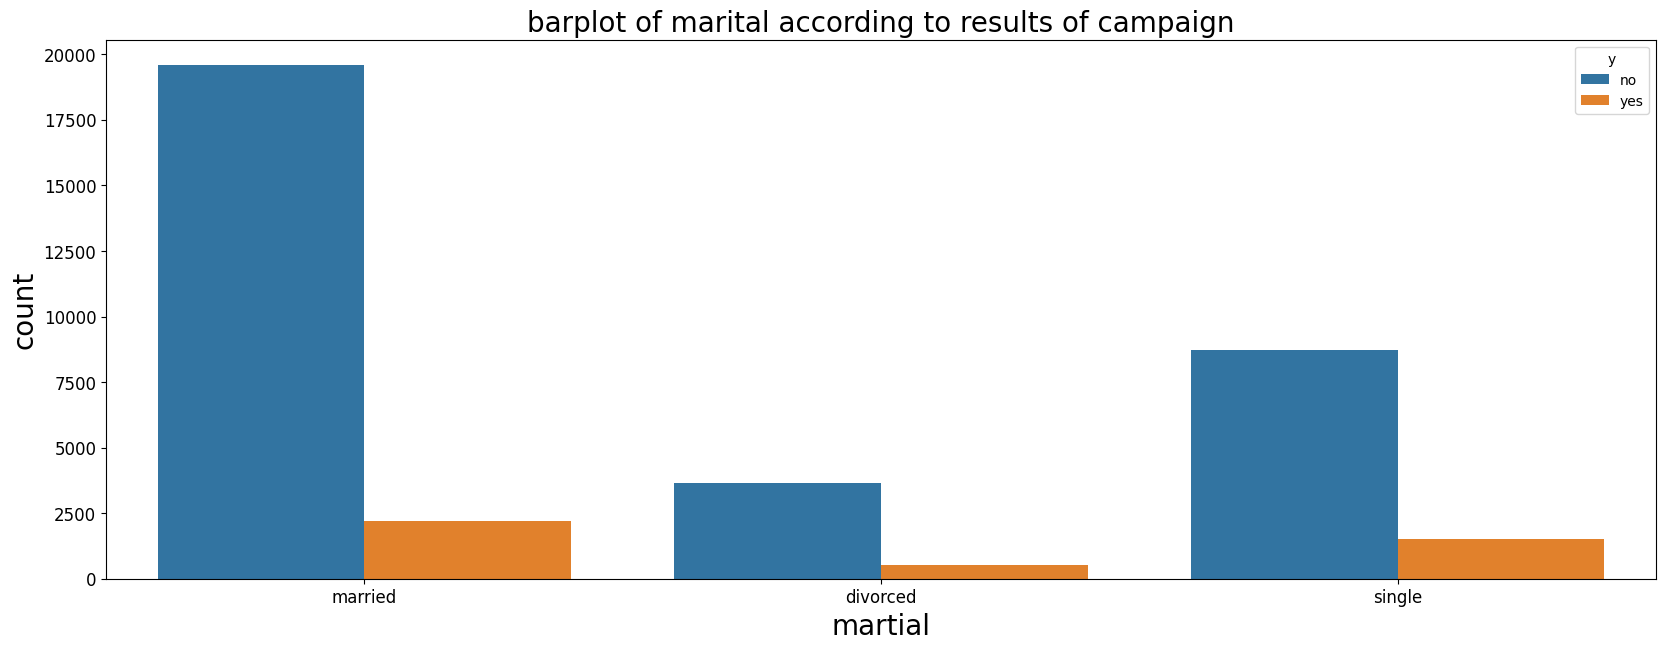

In [29]:
marorder=train_data.groupby('marital').apply(lambda x:sum(x.y=='yes')/sum(x.y=='no')).sort_values(axis=0)
marorder_index=list(marorder.index)
plt.figure(figsize=(20, 7))
sns.countplot(x='marital',hue='y',data=train_data,order=marorder_index)
plt.xticks(size=12,rotation=0)
plt.yticks(size=12)
plt.xlabel('martial',fontdict={'size':20})
plt.ylabel('count',fontdict={'size':20})
plt.title('barplot of marital according to results of campaign',fontdict={'size':20})
plt.savefig("marital.png", dpi=750, bbox_inches = 'tight')

Marital has range of the following values: 'divorced','married','single'. From the barplot above, the married has the census count with the highest subscribed and unsubscribed to a term deposit, followed by the single while the divorced has the lowest or least subscribed and unsubscribed to a term deposit.

- education

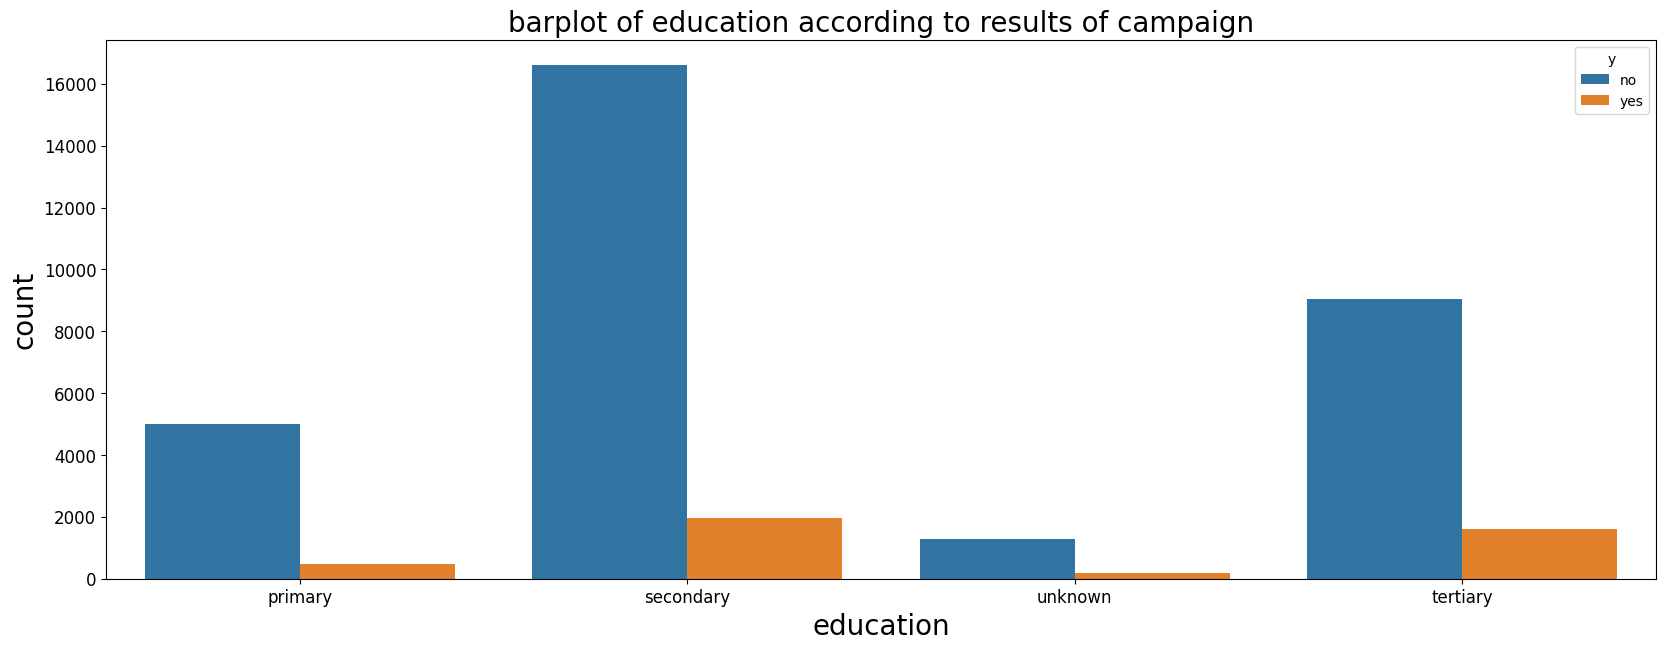

In [30]:
eduorder=train_data.groupby('education').apply(lambda x:sum(x.y=='yes')/sum(x.y=='no')).sort_values(axis=0)
eduorder_index=list(eduorder.index)
plt.figure(figsize=(20, 7))
sns.countplot(x='education',hue='y',data=train_data,order=eduorder_index)
plt.xticks(size=12,rotation=0)
plt.yticks(size=12)
plt.xlabel('education',fontdict={'size':20})
plt.ylabel('count',fontdict={'size':20})
plt.title('barplot of education according to results of campaign',fontdict={'size':20})
plt.savefig("education.png", dpi=750, bbox_inches = 'tight')

Education has four values: 'primary','secondary','tertiary','unknown'. From the barplot above, the secondary has the highest number of subscribed and unsubscribed to a term deposit, followed by the tertiary and primary. We can see that the higher the education level, the higher the subscription rate regardless of the category of unknown.

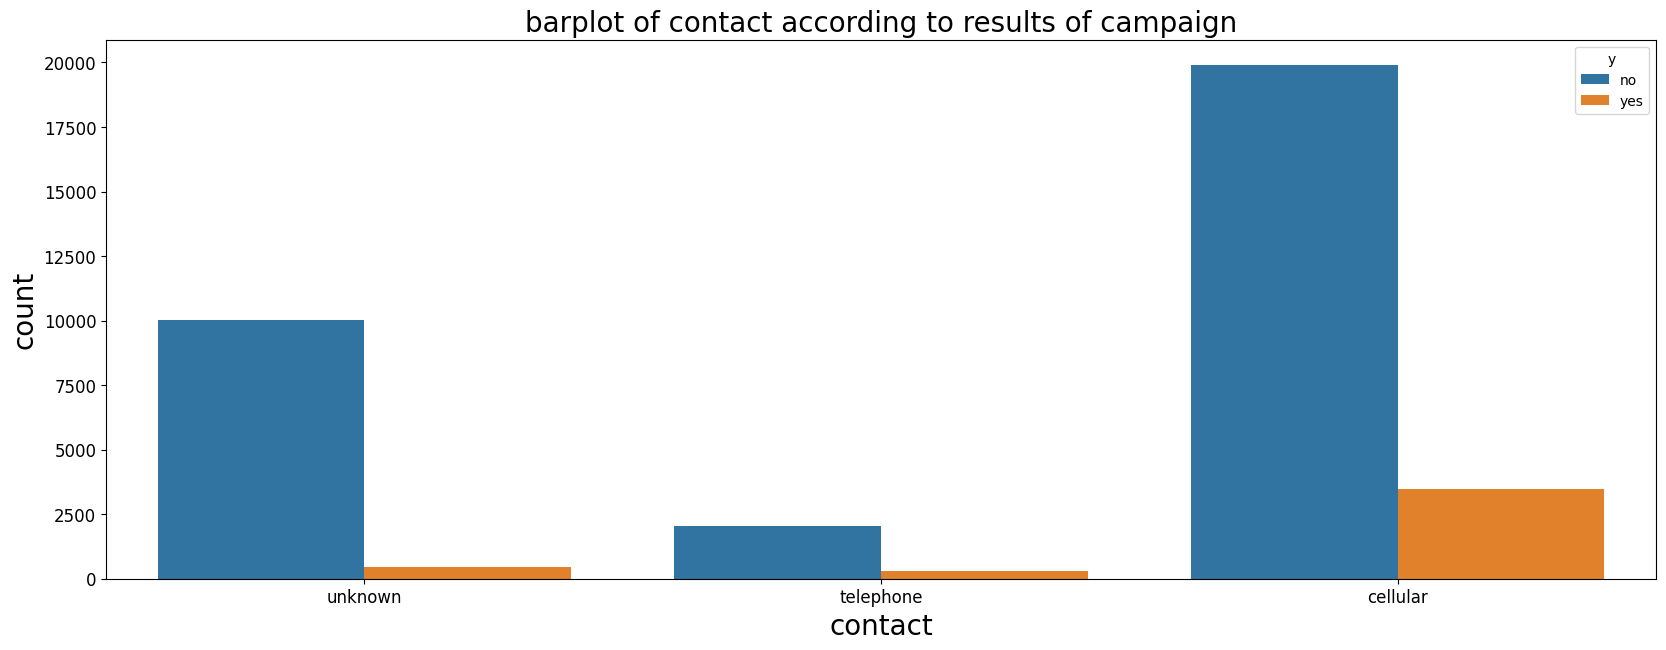

In [31]:
conorder=train_data.groupby('contact').apply(lambda x:sum(x.y=='yes')/sum(x.y=='no')).sort_values(axis=0)
conorder_index=list(conorder.index)
plt.figure(figsize=(20, 7))
sns.countplot(x='contact',hue='y',data=train_data,order=conorder_index)
plt.xticks(size=12,rotation=0)
plt.yticks(size=12)
plt.xlabel('contact',fontdict={'size':20})
plt.ylabel('count',fontdict={'size':20})
plt.title('barplot of contact according to results of campaign',fontdict={'size':20})
plt.savefig("contact.png", dpi=750, bbox_inches = 'tight')

Contact has three values: 'telephone','cellular','unknown'. From the barplot above, the cellular has the highest number of subscribed and unsubscribed to a term deposit. Also, it has the highest subscription rate.

- month

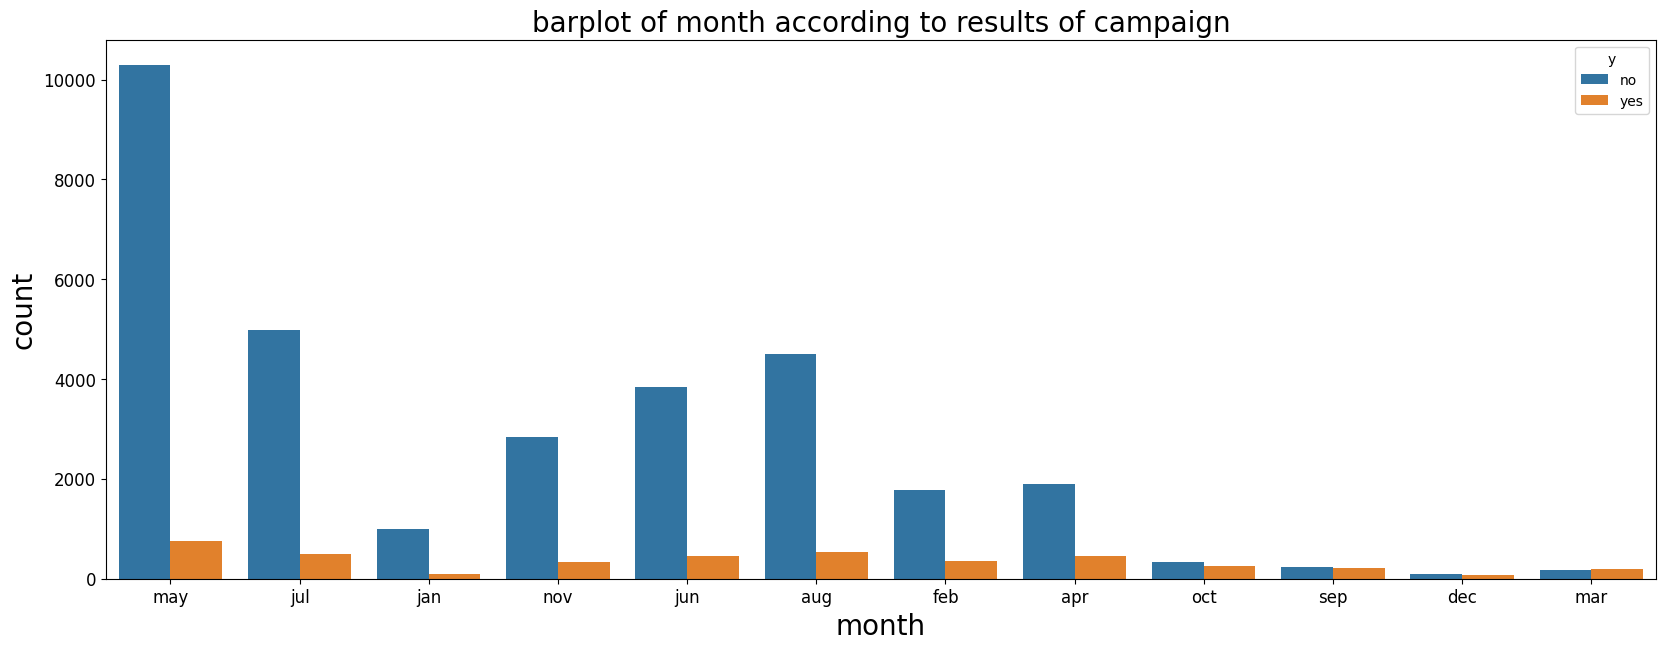

In [32]:
monorder=train_data.groupby('month').apply(lambda x:sum(x.y=='yes')/sum(x.y=='no')).sort_values(axis=0)
monorder_index=list(monorder.index)
plt.figure(figsize=(20, 7))
sns.countplot(x='month',hue='y',data=train_data,order=monorder_index)
plt.xticks(size=12,rotation=0)
plt.yticks(size=12)
plt.xlabel('month',fontdict={'size':20})
plt.ylabel('count',fontdict={'size':20})
plt.title('barplot of month according to results of campaign',fontdict={'size':20})
plt.savefig("month.png", dpi=750, bbox_inches = 'tight')

Month has 12 values from 'January' to 'December'. The contacts were the most in May, June, July and Auguest possibly due to the timing of the campaign launch. However, we guess that this feature may be less important as it does not affect or change the number of clients that
subscribed during the campaign.

- poutcome

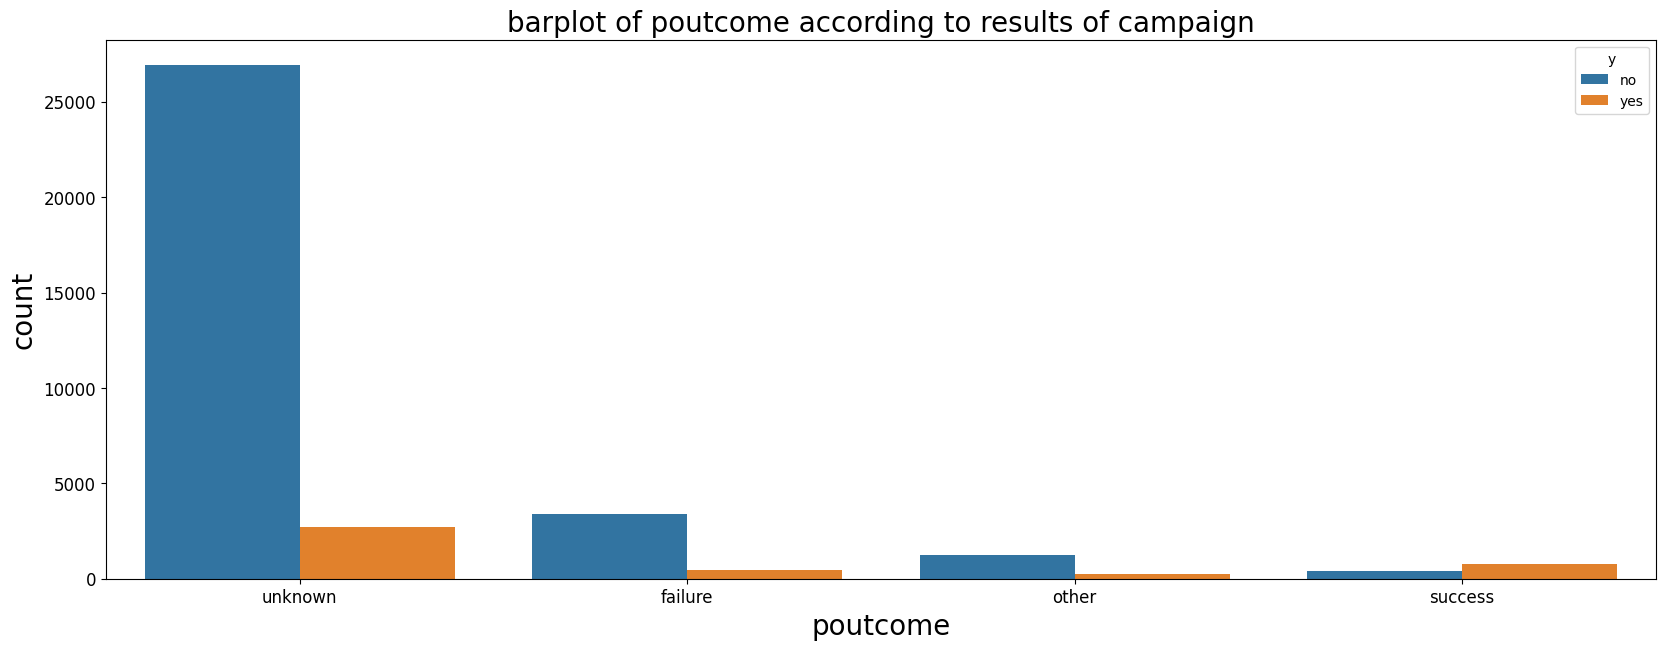

In [33]:
poutorder=train_data.groupby('poutcome').apply(lambda x:sum(x.y=='yes')/sum(x.y=='no')).sort_values(axis=0)
poutorder_index=list(poutorder.index)
plt.figure(figsize=(20, 7))
sns.countplot(x='poutcome',hue='y',data=train_data,order=poutorder_index)
plt.xticks(size=12,rotation=0)
plt.yticks(size=12)
plt.xlabel('poutcome',fontdict={'size':20})
plt.ylabel('count',fontdict={'size':20})
plt.title('barplot of poutcome according to results of campaign',fontdict={'size':20})
plt.savefig("poutcome.png", dpi=750, bbox_inches = 'tight')

Poutcome has four values: 'unknown','failure','other','success'. From the barplot above, the unknown has the highest number of subscribed and unsubscribed to a term deposit because it is the main category. Importantly, customers who have successfully purchased products in previous marketing campaigns are more inclined to subscribe.

- loan,housing,default<br/>
These features are all about credit, so we analyze them together.

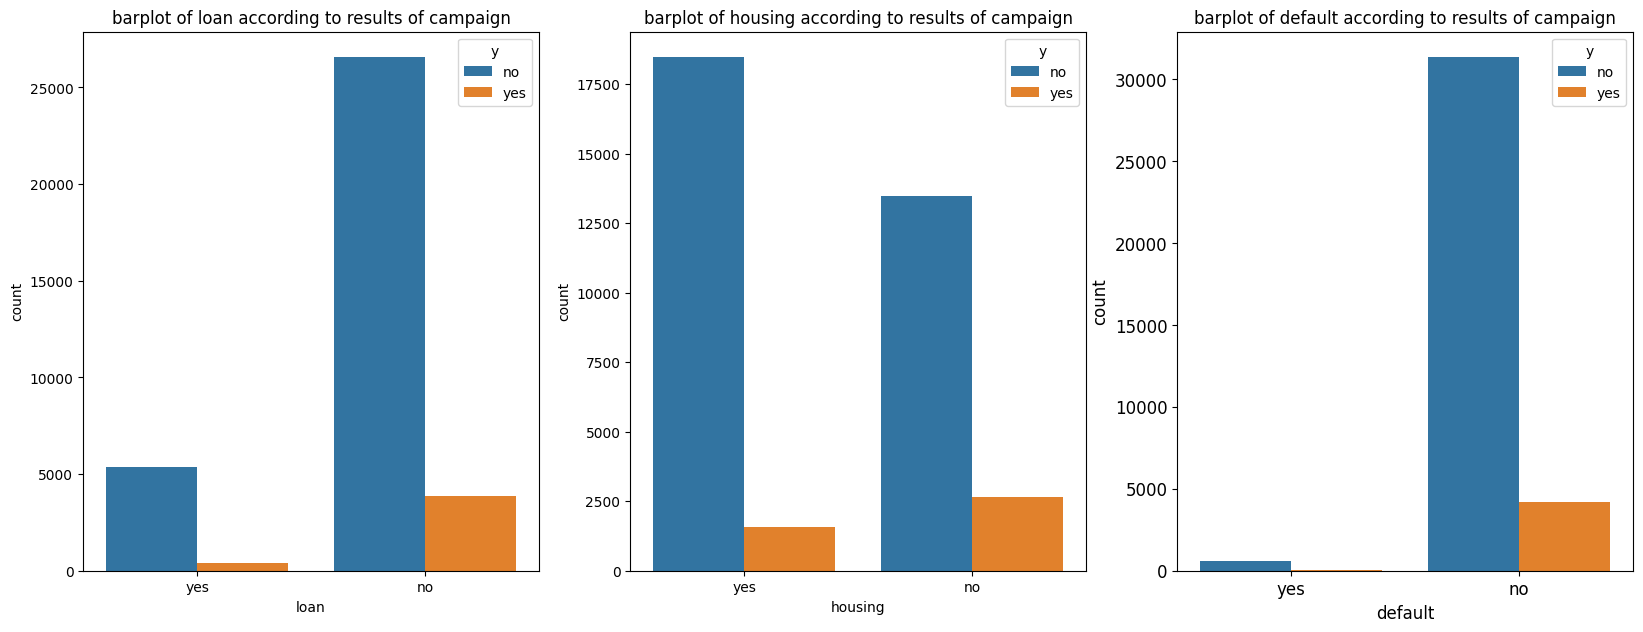

In [34]:
f, ax = plt.subplots(1, 3, figsize=(20,7))
feature=["loan","housing","default"]
for i in range(len(feature)):
    order=train_data.groupby(feature[i]).apply(lambda x:sum(x.y=='yes')/sum(x.y=='no')).sort_values(axis=0)
    order_index=list(order.index)
    sns.countplot(x=feature[i],hue='y',data=train_data,order=order_index,ax=ax[i])
    plt.xticks(size=12,rotation=0)
    plt.yticks(size=12)
    plt.xlabel(feature[i],fontdict={'size':12})
    plt.ylabel('count',fontdict={'size':12})
    ax[i].title.set_text('barplot of '+ str(feature[i])+' according to results of campaign')
plt.savefig("ThreeBinary.png", dpi=750, bbox_inches = 'tight')

It demonstrates that people without personal loan, housing loan and credit in default tend to subscribe the deposit. Possible reasons are less financial pressure. Moreover, the vast majority of customers have not defaulted on their credit so this feature is not very helpful in predicting results.

# 1. Preprocessing Data

## 1.1 Split job into 4 groups based on label

In [35]:
sort_job=train_data.groupby('job').apply(lambda x:sum(x.y=='yes')/len(x)).sort_values(axis=0)
low_level=tuple(sort_job[:4].index.values)
mid_level=tuple(sort_job[4:8].index.values)
advanced_level=tuple(sort_job[8:10].index.values)
high_level=tuple(sort_job[10:].index.values)

In [36]:
train_data.replace({'job': {**{i:1 for i in low_level}, **{i:2 for i in mid_level}, **{i:3 for i in advanced_level}, **{i:4 for i in high_level}}}, inplace=True)
test_data.replace({'job': {**{i:1 for i in low_level}, **{i:2 for i in mid_level}, **{i:3 for i in advanced_level}, **{i:4 for i in high_level}}}, inplace=True)

## 1.2 Fill 999 for -1 in pdays

In [37]:
train_data.replace({'pdays':{-1:999}}, inplace=True)

## 1.3 Label encode education, month, poutcome as well as label

In [38]:
train_data.poutcome.unique()

array(['unknown', 'other', 'failure', 'success'], dtype=object)

In [39]:
train_data.groupby('poutcome').apply(lambda x: sum(x.y == 'yes') / len(x))

poutcome
failure    0.123765
other      0.169685
success    0.653146
unknown    0.091584
dtype: float64

In [40]:
month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
label_dict = {'yes': 1, 'no': 0}
education_dict = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
poutcome_dict = {'unknown': 0, 'other': 2, 'failure': 1, 'success': 3}

train_data['month'] = train_data.month.apply(lambda x: month_dict[x])
train_data['y'] = train_data.y.apply(lambda x: label_dict[x])
train_data['education'] = train_data.education.apply(lambda x: education_dict[x])
train_data['poutcome'] = train_data.poutcome.apply(lambda x: poutcome_dict[x])

test_data['month'] = test_data.month.apply(lambda x: month_dict[x])
test_data['y'] = test_data.y.apply(lambda x: label_dict[x])
test_data['education'] = test_data.education.apply(lambda x: education_dict[x])
test_data['poutcome'] = test_data.poutcome.apply(lambda x: poutcome_dict[x])


In [41]:
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,2,divorced,2,no,-78,yes,yes,cellular,29,7,10,23,999,0,0,0
1,50,3,married,3,no,106,yes,no,unknown,15,5,388,2,999,0,0,0
2,47,2,married,2,no,407,yes,no,unknown,5,6,67,12,999,0,0,0
3,39,2,divorced,2,no,952,yes,no,unknown,16,6,62,1,999,0,0,0
4,30,3,single,3,no,364,no,no,cellular,30,4,306,2,999,0,0,1


## 1.4 One-hot encode marital, default, housing, loan and contact

In [42]:
# one-hot encode job, default, housing, loan, contact
transformer = make_column_transformer((OneHotEncoder(drop='if_binary'), ['marital', 'default', 'housing', 'loan', 'contact']), remainder = 'passthrough').fit(train_data)
train_transformed = transformer.transform(train_data)
test_transformed = transformer.transform(test_data)

train_transformed = pd.DataFrame(train_transformed, columns = transformer.get_feature_names_out())
train_transformed.columns = [i.split('__')[-1] for i in train_transformed.columns]
test_transformed = pd.DataFrame(test_transformed, columns = transformer.get_feature_names_out())
test_transformed.columns = [i.split('__')[-1] for i in test_transformed.columns]

In [43]:
test_transformed.head()

,marital_divorced,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_cellular,contact_telephone,contact_unknown,age,...,education,balance,day,month,duration,campaign,pdays,previous,poutcome,y
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,48.0,...,3.0,468.0,14.0,5.0,220.0,1.0,-1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,31.0,...,3.0,10215.0,22.0,8.0,139.0,2.0,-1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,45.0,...,1.0,900.0,9.0,6.0,213.0,1.0,-1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,58.0,...,1.0,1231.0,20.0,6.0,21.0,3.0,-1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,35.0,...,3.0,5301.0,21.0,11.0,937.0,2.0,-1.0,0.0,0.0,1.0


## 1.5 Cast remaining columns to int

In [44]:
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
int_features = [i for i in train_transformed.columns if i not in numerical_features]

In [45]:
train_transformed = train_transformed.astype({i:'int' for i in int_features})
test_transformed = test_transformed.astype({i:'int' for i in int_features})

In [46]:
train_transformed.head()

,marital_divorced,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_cellular,contact_telephone,contact_unknown,age,...,education,balance,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,0,0,0,1,1,1,0,0,42.0,...,2,-78.0,29,7,10.0,23.0,999.0,0.0,0,0
1,0,1,0,0,1,0,0,0,1,50.0,...,3,106.0,15,5,388.0,2.0,999.0,0.0,0,0
2,0,1,0,0,1,0,0,0,1,47.0,...,2,407.0,5,6,67.0,12.0,999.0,0.0,0,0
3,1,0,0,0,1,0,0,0,1,39.0,...,2,952.0,16,6,62.0,1.0,999.0,0.0,0,0
4,0,0,1,0,0,0,1,0,0,30.0,...,3,364.0,30,4,306.0,2.0,999.0,0.0,0,1


### Correlation plot

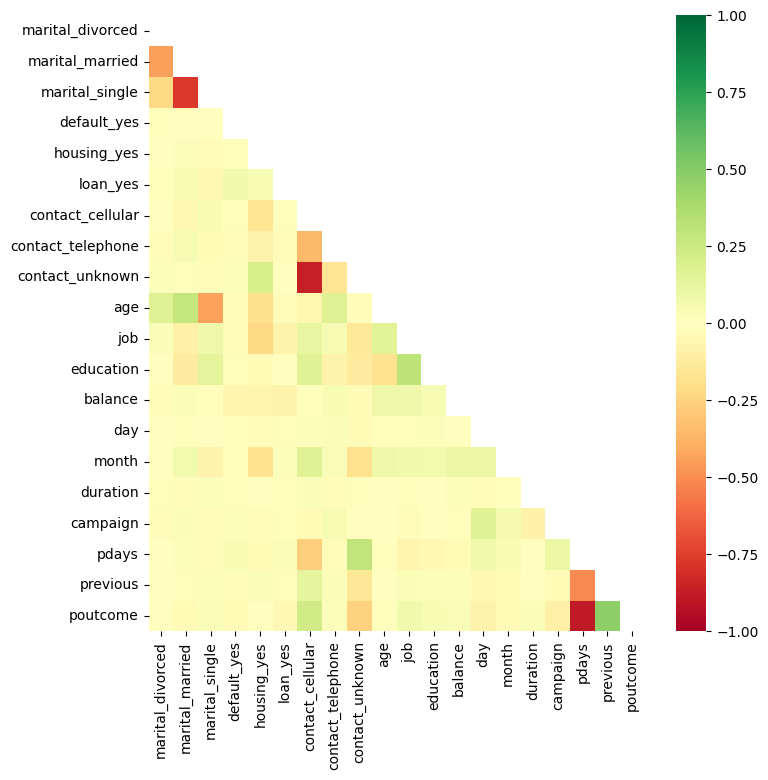

In [47]:
plt.figure(figsize=(8,8))
mask = np.triu(np.ones_like(train_transformed.drop('y',axis=1).corr(), dtype=np.bool))
g=sns.heatmap(train_transformed.drop('y',axis=1).corr(),vmin = -1,vmax = 1,annot=False,cmap="RdYlGn",mask=mask)
plt.savefig("correlation.png", dpi=750, bbox_inches = 'tight')

## 1.6 Split data

In [48]:
xtrain, xval, ytrain, yval = train_test_split(train_transformed.drop('y', axis = 1), train_transformed['y'], test_size=0.2,random_state=5101)
xtest, ytest = test_transformed.drop('y', axis = 1), test_transformed['y']

## 1.7 Downsample train data to n2p = 5

In [49]:
positive_count = sum(ytrain == 1)
negative_indexes = ytrain[ytrain == 0].sample(n = positive_count * 5, random_state=5101).index
all_indexes = negative_indexes.append(ytrain[ytrain == 1].index)


In [50]:
xtrain_sampled = xtrain.loc[all_indexes,:]
ytrain_sampled = ytrain.loc[all_indexes]

## 1.8 Oversample train data using SMOTE

In [51]:
smote=SMOTE(sampling_strategy=0.6,random_state=5101)
xtrain_SMOTE, ytrain_SMOTE = smote.fit_resample(xtrain, ytrain)

# 2 Fit Models

## 2.1 Decision Tree Classifier

### 2.1.1 Train on unsampled data

In [52]:
dt = DecisionTreeClassifier(max_depth=13, min_samples_split=0.4,random_state=5101)
dt.fit(xtrain, ytrain)

DecisionTreeClassifier(max_depth=13, min_samples_split=0.4, random_state=5101)

In [53]:
dtProba = dt.predict_proba(xval)
dtPred = (dtProba[:, 1] >= 0.4).astype('int')

In [54]:
print('precision:', precision_score(yval, dtPred))
print('recall:', recall_score(yval, dtPred))
print('f1:', f1_score(yval, dtPred))
print('accuracy',accuracy_score(yval, dtPred))

precision: 0.4524793388429752
recall: 0.5454545454545454
f1: 0.4946357989836251
accuracy 0.8762786839922588


### 2.1.2 Train on downsampled data

In [55]:
dt2 = DecisionTreeClassifier(random_state=5101)
dt2.fit(xtrain_sampled, ytrain_sampled)

DecisionTreeClassifier(random_state=5101)

In [56]:
dtProba2 = dt2.predict_proba(xval)
dtPred2 = (dtProba2[:, 1] >= 0.4).astype('int')

In [57]:
print('precision:', precision_score(yval, dtPred2))
print('recall:', recall_score(yval, dtPred2))
print('f1:', f1_score(yval, dtPred2))
print('accuracy',accuracy_score(yval, dtPred2))

precision: 0.4393226716839135
recall: 0.5815691158156912
f1: 0.5005359056806002
accuracy 0.8711639480232236


### 2.1.3 Train on SMOTE data

In [58]:
dt3 = DecisionTreeClassifier(max_depth=13, min_samples_split=0.4,random_state=5101)
dt3.fit(xtrain_SMOTE, ytrain_SMOTE)

DecisionTreeClassifier(max_depth=13, min_samples_split=0.4, random_state=5101)

In [59]:
dtProba3 = dt3.predict_proba(xval)
dtPred3= (dtProba3[:, 1] >= 0.4).astype('int')

In [60]:
print('precision:', precision_score(yval, dtPred3))
print('recall:', recall_score(yval, dtPred3))
print('f1:', f1_score(yval, dtPred3))
print('accuracy',accuracy_score(yval, dtPred3))

precision: 0.3010825439783491
recall: 0.5541718555417185
f1: 0.3901797457255589
accuracy 0.807713574785734


### 2.1.4 Parameter tuning using downsampled data

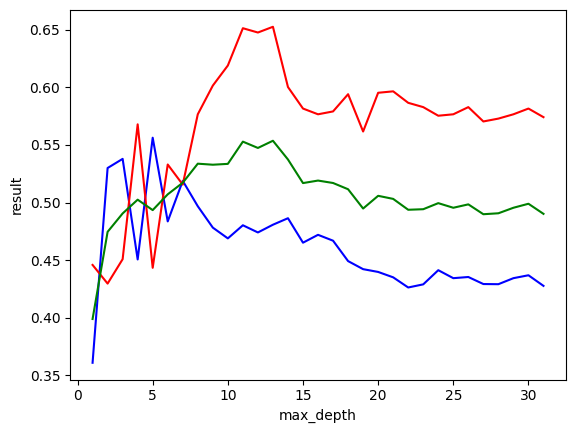

In [61]:
#moudle tuning for max_depths using validation
max_depths = np.arange(1, 32, 1)
max_depths
precision_result = []
recall_result = []
f1_result = []
for max_depth in max_depths:
   model = DecisionTreeClassifier(max_depth=max_depth,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   dtProba2 = model.predict_proba(xval)
   y_pred = (dtProba2[:, 1] >= 0.4).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
line1, = plt.plot(max_depths, precision_result, 'b', label="precision")
line2, = plt.plot(max_depths, recall_result, 'r', label="recall")
line3, = plt.plot(max_depths, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('max_depth')
plt.show()

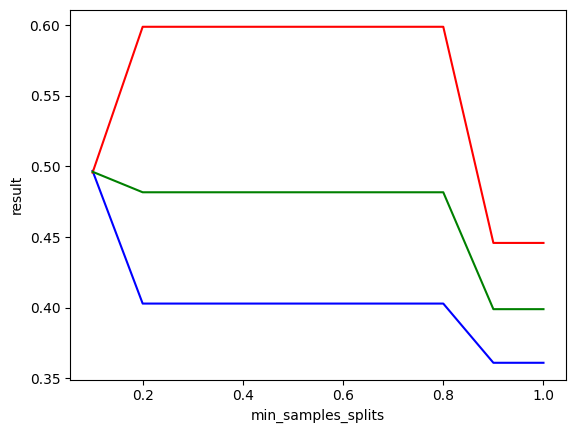

In [62]:
#moudle tuning for min_samples_splits using validation
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
precision_result = []
recall_result = []
f1_result = []
for min_samples_split in min_samples_splits:
   model = DecisionTreeClassifier(max_depth=13,min_samples_split=min_samples_split,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   dtProba2 = model.predict_proba(xval)
   y_pred = (dtProba2[:, 1] >= 0.4).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
line1, = plt.plot(min_samples_splits, precision_result, 'b', label="precision")
line2, = plt.plot(min_samples_splits, recall_result, 'r', label="recall")
line3, = plt.plot(min_samples_splits, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('min_samples_splits')
plt.show()

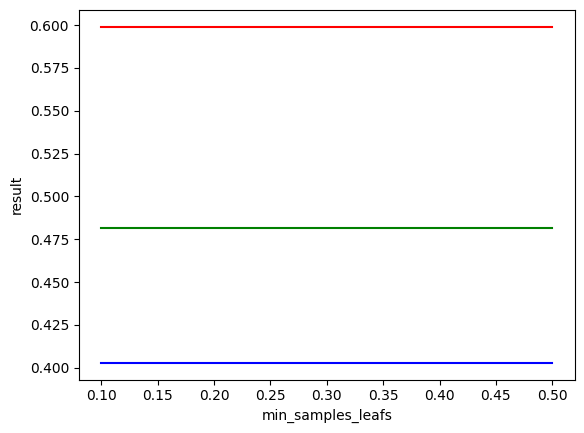

In [63]:
#moudle tuning for min_samples_leafs using validation
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
precision_result = []
recall_result = []
f1_result = []
for min_samples_leaf in min_samples_leafs:
   model = DecisionTreeClassifier(max_depth=13,min_samples_split=0.4,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   dtProba2 = model.predict_proba(xval)
   y_pred = (dtProba2[:, 1] >= 0.4).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
line1, = plt.plot(min_samples_leafs, precision_result, 'b', label="precision")
line2, = plt.plot(min_samples_leafs, recall_result, 'r', label="recall")
line3, = plt.plot(min_samples_leafs, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('min_samples_leafs')
plt.show()

# this para not cause any influence.

## 2.2 Random Forest

### 2.2.1 Train on unsampled data

In [64]:
RFCls = RandomForestClassifier(random_state=5101, n_estimators=400, oob_score=True)
RFCls.fit(xtrain, ytrain)

RandomForestClassifier(n_estimators=400, oob_score=True, random_state=5101)

In [65]:
RFProba = RFCls.predict_proba(xval)
RFPrediction = (RFProba[:, 1] >= 0.4).astype('int')

In [66]:
print('precision:', precision_score(yval, RFPrediction))
print('recall:', recall_score(yval, RFPrediction))
print('f1:', f1_score(yval, RFPrediction))
print('accuracy:', accuracy_score(yval, RFPrediction))

precision: 0.565
recall: 0.5628891656288917
f1: 0.5639426076107299
accuracy: 0.9033729610174177


### 2.2.2 Train on downsampled data

In [67]:
RFCls_sampled = RandomForestClassifier(random_state=5101, n_estimators=200, max_depth=350, oob_score=True)
RFCls_sampled.fit(xtrain_sampled, ytrain_sampled)

RandomForestClassifier(max_depth=350, n_estimators=200, oob_score=True,
                       random_state=5101)

In [68]:
RFProba_sampled = RFCls_sampled.predict_proba(xval)
RFPrediction_sampled = (RFProba_sampled[:, 1] >= 0.4).astype('int')

In [69]:
print('precision:', precision_score(yval, RFPrediction_sampled))
print('recall:', recall_score(yval, RFPrediction_sampled))
print('f1:', f1_score(yval, RFPrediction_sampled))
print('accuracy:', accuracy_score(yval, RFPrediction_sampled))

precision: 0.524733268671193
recall: 0.6737235367372354
f1: 0.5899672846237731
accuracy: 0.8960464473320431


### 2.2.3 Train on SMOTE Data

In [70]:
RFCls_SMOTE = RandomForestClassifier(random_state=5101, n_estimators=400, max_depth=350, oob_score=True)
RFCls_SMOTE.fit(xtrain_SMOTE, ytrain_SMOTE)

RandomForestClassifier(max_depth=350, n_estimators=400, oob_score=True,
                       random_state=5101)

In [71]:
RFProba_SMOTE = RFCls_SMOTE.predict_proba(xval)
RFPrediction_SMOTE = (RFProba_SMOTE[:, 1] >= 0.4).astype('int')

In [72]:
print('precision:', precision_score(yval, RFPrediction_SMOTE))
print('recall:', recall_score(yval, RFPrediction_SMOTE))
print('f1:', f1_score(yval, RFPrediction_SMOTE))
print('accuracy:', accuracy_score(yval, RFPrediction_SMOTE))

precision: 0.4976787372330548
recall: 0.6674968866749689
f1: 0.5702127659574469
accuracy: 0.8883052253248549


## 2.3 Gradient Boosting Classifier

### 2.3.1 Train on unsampled data

In [73]:
gbc = GradientBoostingClassifier(random_state=5101)
gbc.fit(xtrain, ytrain)

GradientBoostingClassifier(random_state=5101)

In [74]:
gbcProba = gbc.predict_proba(xval)
gbcPred = (gbcProba[:, 1] >= 0.2).astype('int')

In [75]:
print('precision:', precision_score(yval, gbcPred))
print('recall:', recall_score(yval, gbcPred))
print('f1:', f1_score(yval, gbcPred))
print('accuracy',accuracy_score(yval, gbcPred))

precision: 0.46843335931410757
recall: 0.7484433374844334
f1: 0.576222435282838
accuracy 0.8777992811722422


### 2.3.2 Train on downsampled data

In [76]:
gbc2 = GradientBoostingClassifier(random_state=5101)
gbc2.fit(xtrain_sampled, ytrain_sampled)

GradientBoostingClassifier(random_state=5101)

In [77]:
gbcProba2 = gbc2.predict_proba(xval)
gbcPred2 = (gbcProba2[:, 1] >= 0.3).astype('int')

In [78]:
print('precision:', precision_score(yval, gbcPred2))
print('recall:', recall_score(yval, gbcPred2))
print('f1:', f1_score(yval, gbcPred2))
print('accuracy',accuracy_score(yval, gbcPred2))

precision: 0.48502495840266224
recall: 0.726027397260274
f1: 0.5815461346633417
accuracy 0.884019905999447


### 2.3.3 Train on SMOTE data

In [79]:
gbc3 = GradientBoostingClassifier(random_state=5101)
gbc3.fit(xtrain_SMOTE, ytrain_SMOTE)

GradientBoostingClassifier(random_state=5101)

In [80]:
gbcProba3 = gbc3.predict_proba(xval)
gbcPred3 = (gbcProba3[:, 1] >= 0.4).astype('int')

In [81]:
print('precision:', precision_score(yval, gbcPred3))
print('recall:', recall_score(yval, gbcPred3))
print('f1:', f1_score(yval, gbcPred3))
print('accuracy',accuracy_score(yval, gbcPred3))

precision: 0.4869015356820235
recall: 0.6712328767123288
f1: 0.5643979057591624
accuracy 0.8849875587503456


### 2.3.4 Parameter tuning using downsampled data 

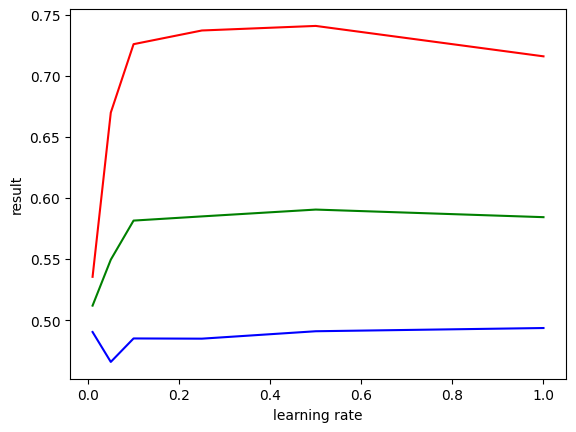

<Figure size 640x480 with 0 Axes>

In [82]:
#module tuning for learning rate using validation 
learning_rates = [1,0.5,0.25, 0.1, 0.05,0.01]
precision_result = []
recall_result = []
f1_result = []
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   gbcProba2 = model.predict_proba(xval)
   y_pred = (gbcProba2[:, 1] >= 0.3).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
line1, = plt.plot(learning_rates, precision_result, 'b', label="precision")
line2, = plt.plot(learning_rates, recall_result, 'r', label="recall")
line3, = plt.plot(learning_rates, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('learning rate')
plt.show()
plt.savefig("learning rate.png", dpi=750, bbox_inches = 'tight')

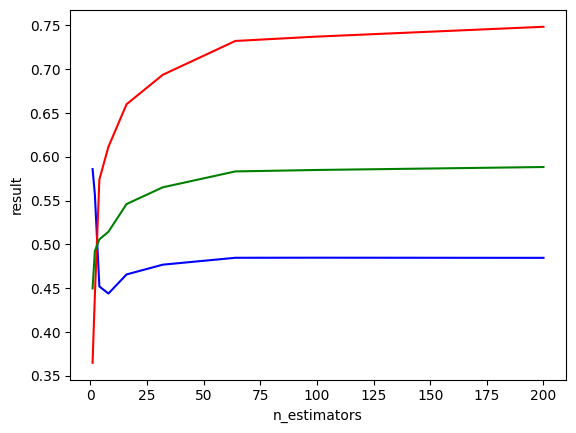

In [83]:
#module tuning for N_estimators using validation 
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
precision_result = []
recall_result = []
f1_result = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(learning_rate=0.25,n_estimators=estimator,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   gbcProba2 = model.predict_proba(xval)
   y_pred = (gbcProba2[:, 1] >= 0.3).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
line1, = plt.plot(n_estimators, precision_result, 'b', label="precision")
line2, = plt.plot(n_estimators, recall_result, 'r', label="recall")
line3, = plt.plot(n_estimators, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('n_estimators')
plt.show()

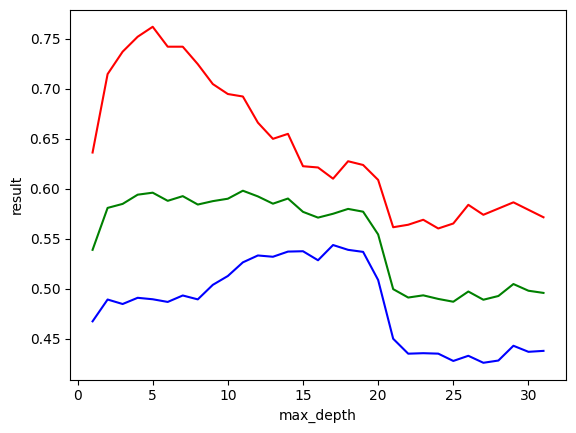

In [84]:
#module tuning for max_depths using validation 
max_depths = np.arange(1, 32, 1)
max_depths
precision_result = []
recall_result = []
f1_result = []
for max_depth in max_depths:
   model = GradientBoostingClassifier(learning_rate=0.25,n_estimators=100,max_depth=max_depth,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   gbcProba2 = model.predict_proba(xval)
   y_pred = (gbcProba2[:, 1] >= 0.3).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
line1, = plt.plot(max_depths, precision_result, 'b', label="precision")
line2, = plt.plot(max_depths, recall_result, 'r', label="recall")
line3, = plt.plot(max_depths, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('max_depth')
plt.show()

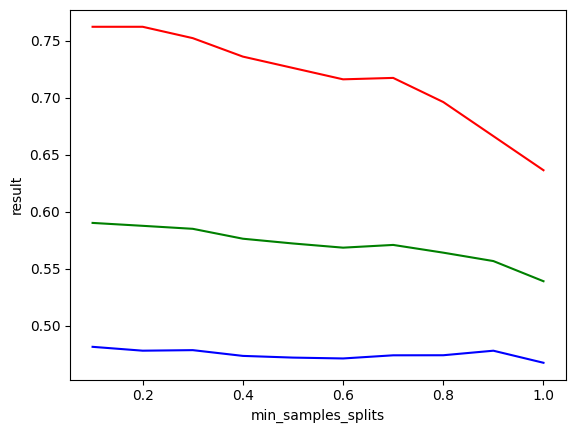

In [85]:
#moduel tuning for min_samples_splits using validation 
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
precision_result = []
recall_result = []
f1_result = []
for min_samples_split in min_samples_splits:
   model = GradientBoostingClassifier(learning_rate=0.25,n_estimators=100,max_depth=6,min_samples_split=min_samples_split,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   gbcProba2 = model.predict_proba(xval)
   y_pred = (gbcProba2[:, 1] >= 0.3).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
line1, = plt.plot(min_samples_splits, precision_result, 'b', label="precision")
line2, = plt.plot(min_samples_splits, recall_result, 'r', label="recall")
line3, = plt.plot(min_samples_splits, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('min_samples_splits')
plt.show()

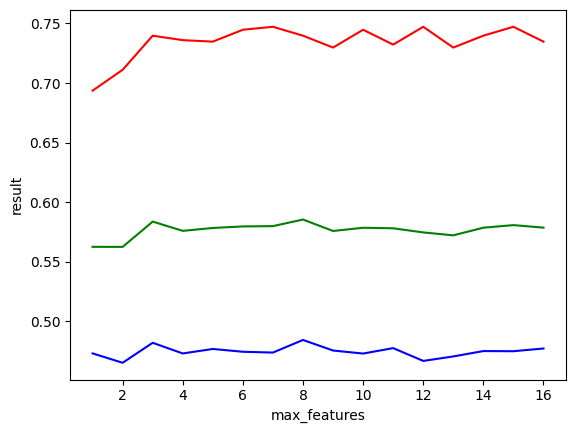

In [86]:
#module tuning for max_features using validation 
max_features = list(range(1,train_data.shape[1]))
precision_result = []
recall_result = []
f1_result = []
for max_feature in max_features:
   model = GradientBoostingClassifier(learning_rate=0.25,n_estimators=100,max_depth=6,min_samples_split=0.3,max_features=max_feature,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   gbcProba2 = model.predict_proba(xval)
   y_pred = (gbcProba2[:, 1] >= 0.3).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
line1, = plt.plot(max_features, precision_result, 'b', label="precision")
line2, = plt.plot(max_features, recall_result, 'r', label="recall")
line3, = plt.plot(max_features, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('max_features')
plt.show()

## 2.4 LightGBM

### 2.4.1 Train on original data

In [87]:
lgbm = LGBMClassifier(class_weight='balanced', n_estimators=49, max_depth=300, random_state=5101)
lgbm.fit(xtrain, ytrain)

LGBMClassifier(class_weight='balanced', max_depth=300, n_estimators=49,
               random_state=5101)

In [88]:
lgbmProba = lgbm.predict_proba(xval)
lgbmPred = (lgbmProba[:, 1] >= 0.7).astype('int')

In [89]:
print('precision:', precision_score(yval, lgbmPred))
print('recall:', recall_score(yval, lgbmPred))
print('f1:', f1_score(yval, lgbmPred))
print('accuracy:', accuracy_score(yval, lgbmPred))

precision: 0.49299258037922505
recall: 0.7447073474470735
f1: 0.5932539682539681
accuracy: 0.8866463920376002


### 2.4.2 Train on downsampled data

In [90]:
lgbm_sampled = LGBMClassifier(class_weight='balanced',n_estimators=49,max_depth=300,random_state=5101)
lgbm_sampled.fit(xtrain_sampled, ytrain_sampled)

LGBMClassifier(class_weight='balanced', max_depth=300, n_estimators=49,
               random_state=5101)

In [91]:
lgbmProba_sampled = lgbm_sampled.predict_proba(xval)
lgbmPred_sampled = (lgbmProba_sampled[:, 1] >= 0.7).astype('int')

In [92]:
print('precision:', precision_score(yval, lgbmPred_sampled))
print('recall:', recall_score(yval, lgbmPred_sampled))
print('f1:', f1_score(yval, lgbmPred_sampled))
print('accuracy:', accuracy_score(yval, lgbmPred_sampled))

precision: 0.499185667752443
recall: 0.763387297633873
f1: 0.6036435253569671
accuracy: 0.8887199336466685


### 2.4.3 Train on SMOTE data

In [93]:
lgbm_SMOTE = LGBMClassifier(class_weight='balanced',n_estimators=49,max_depth=300,random_state=5101)
lgbm_SMOTE.fit(xtrain_SMOTE, ytrain_SMOTE)

LGBMClassifier(class_weight='balanced', max_depth=300, n_estimators=49,
               random_state=5101)

In [94]:
lgbmProba_SMOTE = lgbm_SMOTE.predict_proba(xval)
lgbmPred_SMOTE = (lgbmProba_SMOTE[:, 1] >= 0.4).astype('int')

In [95]:
print('precision:', precision_score(yval, lgbmPred_SMOTE))
print('recall:', recall_score(yval, lgbmPred_SMOTE))
print('f1:', f1_score(yval, lgbmPred_SMOTE))
print('accuracy:', accuracy_score(yval, lgbmPred_SMOTE))

precision: 0.4571016582552271
recall: 0.7895392278953923
f1: 0.5789954337899543
accuracy: 0.8725463090959359


# 3. Refit model and check performance on test, train, validation

In [96]:
# downsample val
positive_count_val = sum(yval == 1)
negative_indexes_val = yval[yval == 0].sample(n = positive_count_val * 5, random_state=5101).index
all_indexes_val = negative_indexes_val.append(yval[yval == 1].index)
xval_sampled = xval.loc[all_indexes_val,:]
yval_sampled = yval.loc[all_indexes_val]

In [97]:
xall = pd.concat([xtrain_sampled, xval_sampled])
yall = pd.concat([ytrain_sampled, yval_sampled])

## 3.1 Decision Tree

In [98]:
dt4 = DecisionTreeClassifier(max_depth=13,min_samples_split=0.4,random_state=5101)
dt4.fit(xall, yall)

DecisionTreeClassifier(max_depth=13, min_samples_split=0.4, random_state=5101)

In [99]:
dtProba6 = dt4.predict_proba(xtrain_sampled)
dtPred6 = (dtProba6[:, 1] >= 0.4).astype('int')

dtProba4 = dt4.predict_proba(xval_sampled)
dtPred4 = (dtProba4[:, 1] >= 0.4).astype('int')

dtProba5 = dt4.predict_proba(xtest)
dtPred5 = (dtProba5[:, 1] >= 0.4).astype('int')

In [100]:
print('\nprecision_train:', precision_score(ytrain_sampled, dtPred6))
print('recall_train:', recall_score(ytrain_sampled, dtPred6))
print('f1_train:', f1_score(ytrain_sampled, dtPred6))
print('accuracy_train',accuracy_score(ytrain_sampled, dtPred6))

print('\nprecision_val:', precision_score(yval_sampled, dtPred4))
print('recall_val:', recall_score(yval_sampled, dtPred4))
print('f1_val:', f1_score(yval_sampled, dtPred4))
print('accuracy_val',accuracy_score(yval_sampled, dtPred4))

print('\nprecision_test:', precision_score(ytest, dtPred5))
print('recall_test:', recall_score(ytest, dtPred5))
print('f1_test:', f1_score(ytest, dtPred5))
print('accuracy_test',accuracy_score(ytest, dtPred5))


precision_train: 0.5514142215173143
recall_train: 0.6085180863477246
f1_train: 0.5785605325197615
accuracy_train 0.8522462077012836

precision_val: 0.5374149659863946
recall_val: 0.5902864259028643
f1_val: 0.5626112759643918
accuracy_val 0.8470319634703196

precision_test: 0.43232044198895025
recall_test: 0.5916824196597353
f1_test: 0.49960095770151636
accuracy_test 0.8613292049098751


Text(0.5, 1.0, 'Decision Tree Precision-Recall curve')

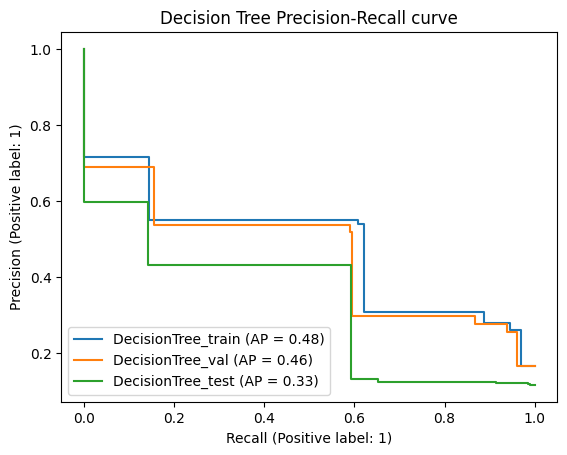

In [101]:
plot_precision_recall_curve(dt4, xtrain_sampled, ytrain_sampled, ax = plt.gca(),name = "DecisionTree_train")
plot_precision_recall_curve(dt4, xval_sampled, yval_sampled, ax = plt.gca(),name = "DecisionTree_val")
plot_precision_recall_curve(dt4, xtest, ytest, ax = plt.gca(),name = "DecisionTree_test")
plt.title('Decision Tree Precision-Recall curve')

## 3.2 Random Forest

In [102]:
RF_all = RandomForestClassifier(random_state=5101, n_estimators=200, max_depth=350, oob_score=True)
RF_all.fit(xall, yall)

RandomForestClassifier(max_depth=350, n_estimators=200, oob_score=True,
                       random_state=5101)

In [103]:
print('\nprecision_train:', precision_score(ytrain_sampled, (RF_all.predict_proba(xtrain_sampled)[:,1] > 0.4).astype('int')))
print('recall_train:', recall_score(ytrain_sampled, (RF_all.predict_proba(xtrain_sampled)[:,1] > 0.4).astype('int')))
print('f1_train:', f1_score(ytrain_sampled, (RF_all.predict_proba(xtrain_sampled)[:,1] > 0.4).astype('int')))
print('accuracy_train', accuracy_score(ytrain_sampled, (RF_all.predict_proba(xtrain_sampled)[:,1] > 0.4).astype('int')))

print('\nprecision_val:', precision_score(yval_sampled, (RF_all.predict_proba(xval_sampled)[:,1] > 0.4).astype('int')))
print('recall_val:', recall_score(yval_sampled, (RF_all.predict_proba(xval_sampled)[:,1] > 0.4).astype('int')))
print('f1_val:', f1_score(yval_sampled, (RF_all.predict_proba(xval_sampled)[:,1] > 0.4).astype('int')))
print('accuracy_val', accuracy_score(yval_sampled, (RF_all.predict_proba(xval_sampled)[:,1] > 0.4).astype('int')))

print('\nprecision_test:', precision_score(ytest, (RF_all.predict_proba(xtest)[:,1] > 0.4).astype('int')))
print('recall_test:', recall_score(ytest, (RF_all.predict_proba(xtest)[:,1] > 0.4).astype('int')))
print('f1_test:', f1_score(ytest, (RF_all.predict_proba(xtest)[:,1] > 0.4).astype('int')))
print('accuracy_test', accuracy_score(ytest, (RF_all.predict_proba(xtest)[:,1] > 0.4).astype('int')))


precision_train: 1.0
recall_train: 1.0
f1_train: 1.0
accuracy_train 1.0

precision_val: 1.0
recall_val: 1.0
f1_val: 1.0
accuracy_val 1.0

precision_test: 0.5192582025677603
recall_test: 0.6880907372400756
f1_test: 0.5918699186991869
accuracy_test 0.8889748977109366


Text(0.5, 1.0, 'Random Forest Precision-Recall curve')

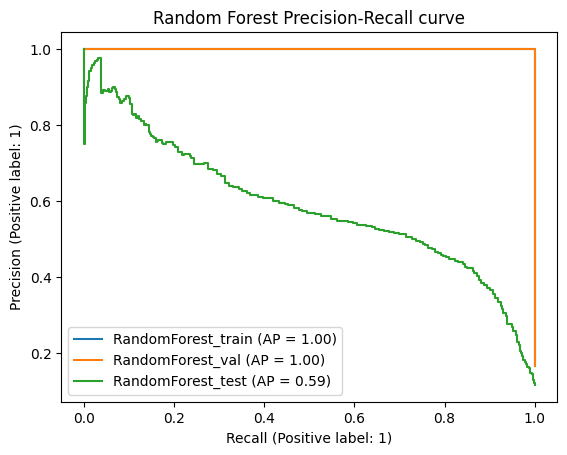

In [104]:
plot_precision_recall_curve(RF_all, xtrain_sampled, ytrain_sampled, ax = plt.gca(),name = "RandomForest_train")

plot_precision_recall_curve(RF_all, xval_sampled, yval_sampled, ax = plt.gca(),name = "RandomForest_val")

plot_precision_recall_curve(RF_all, xtest, ytest, ax = plt.gca(),name = "RandomForest_test")

plt.title('Random Forest Precision-Recall curve')

## 3.3 Gradient Boosting

In [105]:
#gbc4 = GradientBoostingClassifier(learning_rate=0.5,n_estimators=65,max_depth=5,min_samples_split=0.1,max_features=9,random_state=5101)
#gbc4.fit(xall, yall)

In [106]:
gbc4 = GradientBoostingClassifier(learning_rate=0.25,n_estimators=100,max_depth=6,min_samples_split=0.3,max_features=15,random_state=5101)
gbc4.fit(xall, yall)

GradientBoostingClassifier(learning_rate=0.25, max_depth=6, max_features=15,
                           min_samples_split=0.3, random_state=5101)

In [107]:
gbcProba6 = gbc4.predict_proba(xtrain_sampled)
gbcPred6 = (gbcProba6[:, 1] >= 0.3).astype('int')

gbcProba4 = gbc4.predict_proba(xval_sampled)
gbcPred4 = (gbcProba4[:, 1] >= 0.3).astype('int')

gbcProba5 = gbc4.predict_proba(xtest)
gbcPred5 = (gbcProba5[:, 1] >= 0.3).astype('int')

In [108]:
print('\nprecision_train:', precision_score(ytrain_sampled, gbcPred6))
print('recall_train:', recall_score(ytrain_sampled, gbcPred6))
print('f1_train:', f1_score(ytrain_sampled, gbcPred6))
print('accuracy_train',accuracy_score(ytrain_sampled, gbcPred6))

print('\nprecision_val:', precision_score(yval_sampled, gbcPred4))
print('recall_val:', recall_score(yval_sampled, gbcPred4))
print('f1_val:', f1_score(yval_sampled, gbcPred4))
print('accuracy_val',accuracy_score(yval_sampled, gbcPred4))

print('\nprecision_test:', precision_score(ytest, gbcPred5))
print('recall_test:', recall_score(ytest, gbcPred5))
print('f1_test:', f1_score(ytest, gbcPred5))
print('accuracy_test',accuracy_score(ytest, gbcPred5))


precision_train: 0.637591575091575
recall_train: 0.8124270711785297
f1_train: 0.7144689584402257
accuracy_train 0.8917736289381564

precision_val: 0.6095617529880478
recall_val: 0.7621419676214197
f1_val: 0.677365799667958
accuracy_val 0.8789954337899544

precision_test: 0.4432008953553441
recall_test: 0.7485822306238186
f1_test: 0.5567662565905096
accuracy_test 0.8605551255114453


Text(0.5, 1.0, 'Gradient Boosting Precision-Recall curve')

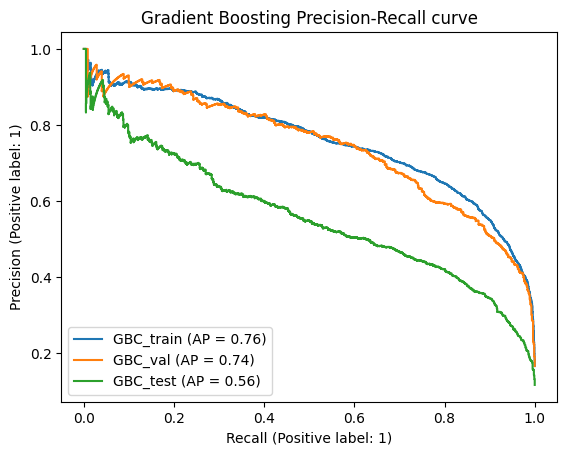

In [109]:
plot_precision_recall_curve(gbc4, xtrain_sampled, ytrain_sampled, ax = plt.gca(),name = "GBC_train")

plot_precision_recall_curve(gbc4, xval_sampled, yval_sampled, ax = plt.gca(),name = "GBC_val")

plot_precision_recall_curve(gbc4, xtest, ytest, ax = plt.gca(),name = "GBC_test")

plt.title('Gradient Boosting Precision-Recall curve')

## 3.4 LGBM

In [110]:
lgbm_all = LGBMClassifier(class_weight='balanced',n_estimators=49,max_depth=300,random_state=5101)
lgbm_all.fit(xall, yall)

LGBMClassifier(class_weight='balanced', max_depth=300, n_estimators=49,
               random_state=5101)

In [111]:
lgbmProba_train = lgbm_all.predict_proba(xtrain_sampled)
lgbmPred_train = (lgbmProba_train[:, 1] >= 0.7).astype('int')

lgbmProba_val = lgbm_all.predict_proba(xval_sampled)
lgbmPred_val = (lgbmProba_val[:, 1] >= 0.7).astype('int')

lgbmProba_test = lgbm_all.predict_proba(xtest)
lgbmPred_test = (lgbmProba_test[:, 1] >= 0.7).astype('int')

In [112]:
print('\nprecision_train:', precision_score(ytrain_sampled, lgbmPred_train))
print('recall_train:', recall_score(ytrain_sampled, lgbmPred_train))
print('f1_train:', f1_score(ytrain_sampled, lgbmPred_train))
print('accuracy_train:', accuracy_score(ytrain_sampled, lgbmPred_train))

print('\nprecision_val:', precision_score(yval_sampled, lgbmPred_val))
print('recall_val:', recall_score(yval_sampled, lgbmPred_val))
print('f1_val:', f1_score(yval_sampled, lgbmPred_val))
print('accuracy_val:', accuracy_score(yval_sampled, lgbmPred_val))

print('\nprecision_test:', precision_score(ytest, lgbmPred_test))
print('recall_test:', recall_score(ytest, lgbmPred_test))
print('f1_test:', f1_score(ytest, lgbmPred_test))
print('accuracy_test:', accuracy_score(ytest, lgbmPred_test))


precision_train: 0.6420364947060149
recall_train: 0.8313885647607935
f1_train: 0.7245455701029617
accuracy_train: 0.8946421625826526

precision_val: 0.6248775710088149
recall_val: 0.7945205479452054
f1_val: 0.6995614035087719
accuracy_val: 0.8862598588625986

precision_test: 0.5018939393939394
recall_test: 0.7514177693761814
f1_test: 0.6018168054504164
accuracy_test: 0.8836669246931328


Text(0.5, 1.0, 'LGBM Precision-Recall curve')

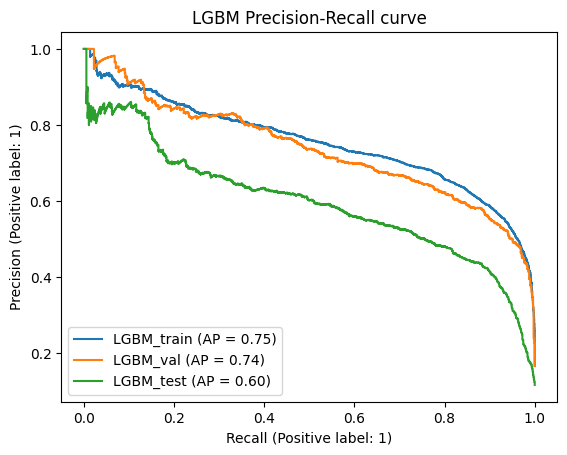

In [113]:
plot_precision_recall_curve(lgbm_all, xtrain_sampled, ytrain_sampled, ax = plt.gca(),name = "LGBM_train")

plot_precision_recall_curve(lgbm_all, xval_sampled, yval_sampled, ax = plt.gca(),name = "LGBM_val")

plot_precision_recall_curve(lgbm_all, xtest, ytest, ax = plt.gca(),name = "LGBM_test")

plt.title('LGBM Precision-Recall curve')

# 4. Feature Importance on Best model

<AxesSubplot: title={'center': 'feature_importance'}, xlabel='feature_score', ylabel='feature_name'>

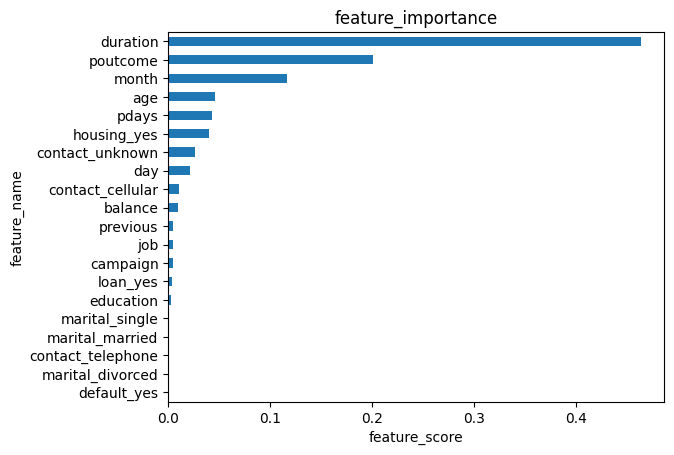

In [118]:
pd.Series(gbc4.feature_importances_, index=gbc4.feature_names_in_).sort_values(ascending=True).plot(kind='barh', xlabel = 'feature_score', ylabel = 'feature_name', title='feature_importance')

<AxesSubplot: title={'center': 'feature_importance'}, xlabel='feature_score', ylabel='feature_name'>

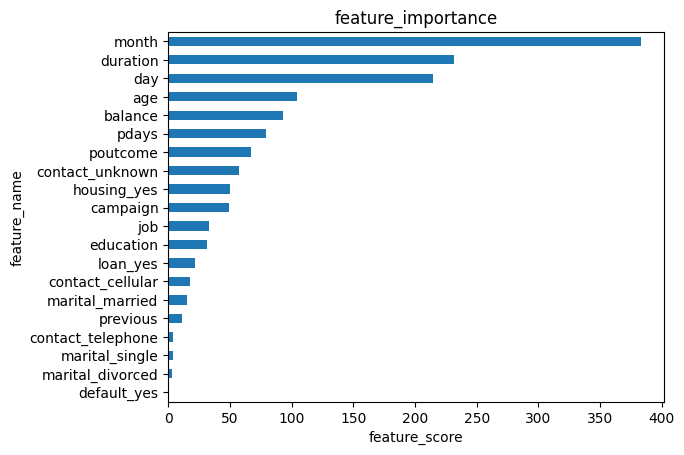

In [115]:
pd.Series(lgbm_all.feature_importances_, index=lgbm_all.feature_name_).sort_values(ascending=True).plot(kind='barh', xlabel = 'feature_score', ylabel = 'feature_name', title='feature_importance')

In [116]:
pd.concat([xall, yall], axis=1).groupby('month').apply(lambda x: sum(x.y == 1) / len(x))

month
1     0.136063
2     0.232190
3     0.636656
4     0.266314
5     0.098790
6     0.151801
7     0.131118
8     0.150604
9     0.557841
10    0.537344
11    0.152448
12    0.628788
dtype: float64

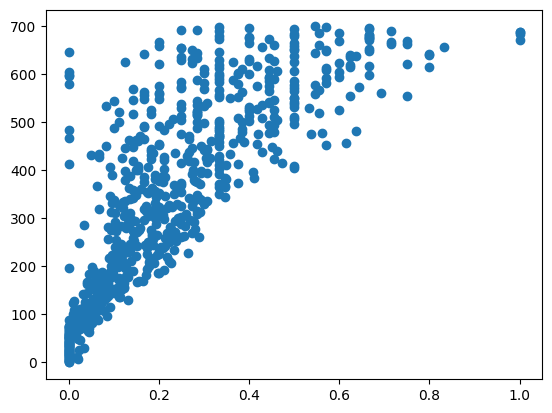

In [117]:
temp = pd.concat([xall, yall], axis=1).groupby('duration').apply(lambda x: sum(x.y == 1) / len(x))
temp = temp[:700]
temp.reset_index()
plt.scatter(temp, temp.index)